# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


Le projet a été préparé par Gabriel Gobeil, associé de recherche à Polytechnique Montréal.

---
# Projet A2022 : Récolte des cerfs de Virginie


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/23b6d8c44f1247c78e19a6a902f804af

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- recolte.csv
- permis.csv
- meteo.csv
- essence.csv
- test.csv

**Déposez ces fichiers dans un dossier nommé *data* dans le répertoire de ce calepin.**

Le fichier *recolte.csv* contient les statistiques de chasse au cerf de Viriginie. On y retrouve le nombre de cerfs mâles adultes récoltés annuellement dans certaines zones de chasse du Québec, listé selon le type d'engin utilisé.

Le fichier *permis.csv* contient des informations sur le nombre de permis de chasse aux cerfs de Virginie alloués aux résidents et non-résidents de 1999 à 2020.

Le fichier *meteo.csv* contient certaines variables météorologiques enregistrées à la station Montréal-Trudeau de 1999 à 2021 :
- Mean Temp (°C)	
- Total Rain (mm)	
- Total Snow (cm)	
- Snow on Grnd (cm)

Le fichier *essence.csv* contient des informations sur le prix de détail moyen par mois de l'essence pour Québec et Montréal de 1999 à 2021. Des renseignements additionnels sur les données sont disponibles à l'adresse suivante : https://www150.statcan.gc.ca/t1/tbl1/fr/cv.action?pid=1810000101

Le fichier *test.csv* contient les zones de chasse pour lesquels vous devez prédire le nombre de cerfs mâles adultes récoltés pour l'année 2021, peu importe l'engin de chasse utilisé. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est suffisante.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Distributions, LinearAlgebra, GLM, Combinatorics, StatsBase

---
## 1. Chargement de données

#### Récolte annuelle de cerfs par zones de chasse selon les différents engins

In [2]:
recolte = CSV.read("data/recolte.csv", DataFrame)
first(recolte, 5)

5×4 DataFrame
 Row │ Année  Zone   Engin        Cerfs 
     │ Int64  Int64  String15     Int64 
─────┼──────────────────────────────────
   1 │  1999      2  Arc             58
   2 │  1999      2  Carabine       852
   3 │  1999      2  Indéterminé     12
   4 │  1999      3  Arc             94
   5 │  1999      3  Carabine      1422

#### Nombre de permis de chasse alloués annuellement aux résidents et non-résidents

In [3]:
permis = CSV.read("data/permis.csv", DataFrame)
n = size(permis,1)
for i in range(1, n)
    residents_premier_abbatage = permis[i, :"Résidents premier abbatage"]
    if (ismissing(residents_premier_abbatage))
        permis[i, :"Résidents premier abbatage"] = 0
    end
end

permis.Total = [permis[i, :Résidents] + permis[i, :"Résidents premier abbatage"] + permis[i, :"Non-résidents"] for i in 1:n]
first(permis, 5)

5×5 DataFrame
 Row │ Année  Résidents  Résidents premier abbatage  Non-résidents  Total  
     │ Int64  Int64?     Int64?                      Int64?         Int64? 
─────┼─────────────────────────────────────────────────────────────────────
   1 │  1998     135409                           0           1230  136639
   2 │  1999     131325                           0           1260  132585
   3 │  2000     137346                           0           1463  138809
   4 │  2001     144074                           0           1551  145625
   5 │  2002     151154                           0           1735  152889

#### Moyenne mensuelle du prix de détail de l'essence en cents pour Québec et Montréal

In [4]:
essence = CSV.read("data/essence.csv", DataFrame)
first(essence, 5)

5×3 DataFrame
 Row │ Mois        Québec   Montréal 
     │ Date        Float64  Float64  
─────┼───────────────────────────────
   1 │ 1997-04-01     60.1      60.3
   2 │ 1997-05-01     60.7      60.5
   3 │ 1997-06-01     59.4      61.5
   4 │ 1997-07-01     57.9      59.7
   5 │ 1997-08-01     62.8      64.0

#### Données météorologiques quotidiennes à Montréal-Trudeau entre 1999 et 2021

In [5]:
meteo = CSV.read("data/meteo.csv", DataFrame)
n = size(meteo,1)
meteo.Année = [Dates.year(meteo[i, :"Date/Time"]) for i in 1:n]

first(meteo, 5)

5×6 DataFrame
 Row │ Date/Time   Mean Temp (°C)  Total Rain (mm)  Total Snow (cm)  Snow on G ⋯
     │ Date        Float64?        Float64?         Float64?         Int64?    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1999-01-01           -20.5              0.0              1.0            ⋯
   2 │ 1999-01-02           -19.2              0.0              0.0
   3 │ 1999-01-03            -8.5              1.2             11.4
   4 │ 1999-01-04            -9.4              0.0              0.0
   5 │ 1999-01-05           -14.3              0.0              0.0            ⋯
                                                               2 columns omitted

#### Construction du tableau des variables transformée en données anuelles
Sachant que la période de chasse est qu'en automne de chaque année, nous pensons que seule les données de météo et du prix de l'essence durant cette période sera pertinente pour notre analyse des variables.

##### Température moyenne annuelle

In [6]:
Temp = CSV.read("data/meteo.csv", DataFrame)
# On remplace les données manquantes par 0
  n = length(Temp[!, "Mean Temp (°C)"])
    for i = 1:n
        Temp[!, "Mean Temp (°C)"][i] = Temp[!, "Mean Temp (°C)"][i] !== missing ?  Temp[!, "Mean Temp (°C)"][i] : 0.0
    end
# conversion des températures en kelvin, pour ne pas avoir de températures négative
    n = length(Temp[!, "Mean Temp (°C)"])
    for i = 1:n
        Temp[!, "Mean Temp (°C)"][i] = Temp[!, "Mean Temp (°C)"][i] + 273
    end

rename!(Temp, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 
#sélection des donnée de l'automne, donc de septembre à novembre de chaque années
Temp = Temp[[10 <= Dates.month(Temp.Année[i]) <= 11 for i in 1:length(Temp.Année)], :]

Temp[!,"Année"] = [item == item ? Dates.year(item) : "" for item in Temp[!,"Année"]] #Utilisation de l'année seulement
TempMoy = DataFrame(Année = Int64[], Temp = Float64[])
TempMoy = combine(groupby(Temp, :Année), :"Mean Temp (°C)" => mean∘skipmissing => :"Température")
push!(TempMoy, [2013, 0.0])
Temp2021 = TempMoy.Température[22]
TempMoy

23×2 DataFrame
 Row │ Année  Température 
     │ Int64  Float64     
─────┼────────────────────
   1 │  1999      279.367
   2 │  2000      278.813
   3 │  2001      280.598
   4 │  2002      276.943
   5 │  2003      278.477
   6 │  2004      278.641
   7 │  2005      279.539
   8 │  2006      279.195
   9 │  2007      279.287
  10 │  2008      278.295
  11 │  2009      278.705
  12 │  2010      278.425
  13 │  2011      280.636
  14 │  2012      278.754
  15 │  2014      279.464
  16 │  2015      279.105
  17 │  2016      279.875
  18 │  2017      279.964
  19 │  2018      276.113
  20 │  2019      277.289
  21 │  2020      279.649
  22 │  2021      280.133
  23 │  2013        0.0

##### Pluie totale annuelle

In [7]:
Pluie = CSV.read("data/meteo.csv", DataFrame)
rename!(Pluie, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
Pluie = Pluie[[10 <= Dates.month(Pluie.Année[i]) <= 11 for i in 1:length(Pluie.Année)], :]

Pluie[!,"Année"] = [item == item ? Dates.year(item) : "" for item in Pluie[!,"Année"]]
# On remplace les données manquantes par 0
    n = length(Pluie[!, "Total Rain (mm)"])
    for i = 1:n
        Pluie[!, "Total Rain (mm)"][i] = Pluie[!, "Total Rain (mm)"][i] !== missing ?  Pluie[!, "Total Rain (mm)"][i] : 0.0
    end
PluieAn = combine(groupby(Pluie, :Année), :"Total Rain (mm)" => sum => :"Pluie_totale")
push!(PluieAn, [2013, 0.0])

23×2 DataFrame
 Row │ Année  Pluie_totale 
     │ Int64  Float64      
─────┼─────────────────────
   1 │  1999         139.7
   2 │  2000          79.9
   3 │  2001         155.9
   4 │  2002         108.9
   5 │  2003         287.4
   6 │  2004         122.6
   7 │  2005         279.8
   8 │  2006         250.8
   9 │  2007         162.0
  10 │  2008         156.6
  11 │  2009         161.0
  12 │  2010         206.0
  13 │  2011         142.6
  14 │  2012         108.0
  15 │  2014         120.2
  16 │  2015         146.6
  17 │  2016         209.4
  18 │  2017         202.4
  19 │  2018         154.4
  20 │  2019         294.4
  21 │  2020         150.4
  22 │  2021         168.2
  23 │  2013           0.0

##### Neige total tombée annuelle

In [8]:
Neige = CSV.read("data/meteo.csv", DataFrame)
rename!(Neige, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
Neige = Neige[[10 <= Dates.month(Neige.Année[i]) <= 11 for i in 1:length(Neige.Année)], :]

Neige[!,"Année"] = [item == item ? Dates.year(item) : "" for item in Neige[!,"Année"]]
# On remplace les données manquantes par 0
    n = length(Neige[!, "Total Snow (cm)"])
    for i = 1:n
        Neige[!, "Total Snow (cm)"][i] = Neige[!, "Total Snow (cm)"][i] !== missing ?  Neige[!, "Total Snow (cm)"][i] : 0.0
    end
NeigeAn = combine(groupby(Neige, :Année), :"Total Snow (cm)" => sum => :"Neige_totale")
push!(NeigeAn, [2013, 0.0])

23×2 DataFrame
 Row │ Année  Neige_totale 
     │ Int64  Float64      
─────┼─────────────────────
   1 │  1999           5.1
   2 │  2000           9.6
   3 │  2001           4.6
   4 │  2002          63.3
   5 │  2003           2.8
   6 │  2004           0.4
   7 │  2005          13.6
   8 │  2006           0.0
   9 │  2007          29.0
  10 │  2008          15.6
  11 │  2009           6.4
  12 │  2010           5.6
  13 │  2011           8.2
  14 │  2012           1.0
  15 │  2014          17.2
  16 │  2015           3.2
  17 │  2016          10.0
  18 │  2017           6.0
  19 │  2018          44.0
  20 │  2019          31.6
  21 │  2020          22.4
  22 │  2021           3.8
  23 │  2013           0.0

#### Neige totale sur le sol annuelle

In [9]:
NeigeSol = CSV.read("data/meteo.csv", DataFrame)
rename!(NeigeSol, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
NeigeSol = NeigeSol[[10 <= Dates.month(NeigeSol.Année[i]) <= 11 for i in 1:length(NeigeSol.Année)], :]

NeigeSol[!,"Année"] = [item == item ? Dates.year(item) : "" for item in NeigeSol[!,"Année"]]
# On remplace les données manquantes par 0
    n = length(NeigeSol[!, "Snow on Grnd (cm)"])
    for i = 1:n
        NeigeSol[!, "Snow on Grnd (cm)"][i] = NeigeSol[!, "Snow on Grnd (cm)"][i] !== missing ?  NeigeSol[!, "Snow on Grnd (cm)"][i] : 0.0
    end
NeigeSolAn = combine(groupby(NeigeSol, :Année), :"Snow on Grnd (cm)" => sum => :"Neige_totale_au_sol")
push!(NeigeSolAn, [2013, 0.0])

23×2 DataFrame
 Row │ Année  Neige_totale_au_sol 
     │ Int64  Int64               
─────┼────────────────────────────
   1 │  1999                    2
   2 │  2000                   13
   3 │  2001                    2
   4 │  2002                   68
   5 │  2003                    1
   6 │  2004                    0
   7 │  2005                   20
   8 │  2006                    0
   9 │  2007                   52
  10 │  2008                    3
  11 │  2009                    1
  12 │  2010                    0
  13 │  2011                   12
  14 │  2012                    0
  15 │  2014                   19
  16 │  2015                    1
  17 │  2016                   17
  18 │  2017                    8
  19 │  2018                   58
  20 │  2019                   47
  21 │  2020                   13
  22 │  2021                    6
  23 │  2013                    0

#### Nombre de jours ayant de la neige au sol dans l'année

In [10]:
JourNeigeSol = CSV.read("data/meteo.csv", DataFrame)
rename!(JourNeigeSol, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
JourNeigeSol = JourNeigeSol[[10 <= Dates.month(JourNeigeSol.Année[i]) <= 11 for i in 1:length(JourNeigeSol.Année)], :]

JourNeigeSol[!,"Année"] = [item == item ? Dates.year(item) : "" for item in JourNeigeSol[!,"Année"]]
# On remplace les jours où on a une donnée  par 1.0, pour signifier qu'il a de la neige au sol 
    n = length(JourNeigeSol[!, "Snow on Grnd (cm)"])
    for i = 1:n
        JourNeigeSol[!, "Snow on Grnd (cm)"][i] = JourNeigeSol[!, "Snow on Grnd (cm)"][i] !== missing ?  JourNeigeSol[!, "Snow on Grnd (cm)"][i] : 0
        JourNeigeSol[!, "Snow on Grnd (cm)"][i] = JourNeigeSol[!, "Snow on Grnd (cm)"][i] !== 0 ?  1 : 0
    end
JourNeigeSolAn = combine(groupby(JourNeigeSol, :Année), :"Snow on Grnd (cm)" => sum => :"Jours_neige_au_sol")
push!(JourNeigeSolAn, [2013, 0.0])

23×2 DataFrame
 Row │ Année  Jours_neige_au_sol 
     │ Int64  Int64              
─────┼───────────────────────────
   1 │  1999                   1
   2 │  2000                   5
   3 │  2001                   1
   4 │  2002                  14
   5 │  2003                   1
   6 │  2004                   0
   7 │  2005                   6
   8 │  2006                   0
   9 │  2007                   9
  10 │  2008                   1
  11 │  2009                   1
  12 │  2010                   0
  13 │  2011                   2
  14 │  2012                   0
  15 │  2014                   6
  16 │  2015                   1
  17 │  2016                   6
  18 │  2017                   5
  19 │  2018                  13
  20 │  2019                  12
  21 │  2020                   4
  22 │  2021                   3
  23 │  2013                   0

#### Nombre de jours où il a plu dans l'année

In [11]:
JourPluie = CSV.read("data/meteo.csv", DataFrame)
rename!(JourPluie, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
JourPluie = JourPluie[[10 <= Dates.month(JourPluie.Année[i]) <= 11 for i in 1:length(JourPluie.Année)], :]

JourPluie[!,"Année"] = [item == item ? Dates.year(item) : "" for item in JourPluie[!,"Année"]]
# On remplace les jours où on a une donnée  par 1.0, pour signifier qu'il a de la pluie 
    n = length(JourPluie[!, "Total Rain (mm)"])
    for i = 1:n
        JourPluie[!, "Total Rain (mm)"][i] = JourPluie[!, "Total Rain (mm)"][i] !== missing ?  JourPluie[!, "Total Rain (mm)"][i] : 0
        JourPluie[!, "Total Rain (mm)"][i] = JourPluie[!, "Total Rain (mm)"][i] !== 0.0 ?  1.0 : 0.0
    end
JourPluieAn = combine(groupby(JourPluie, :Année), :"Total Rain (mm)" => sum => :"Jours_de_pluie")
push!(JourPluieAn, [2013, 0.0])

23×2 DataFrame
 Row │ Année  Jours_de_pluie 
     │ Int64  Float64        
─────┼───────────────────────
   1 │  1999            26.0
   2 │  2000            19.0
   3 │  2001            33.0
   4 │  2002            22.0
   5 │  2003            25.0
   6 │  2004            20.0
   7 │  2005            31.0
   8 │  2006            33.0
   9 │  2007            24.0
  10 │  2008            22.0
  11 │  2009            25.0
  12 │  2010            26.0
  13 │  2011            22.0
  14 │  2012            22.0
  15 │  2014            27.0
  16 │  2015            22.0
  17 │  2016            26.0
  18 │  2017            26.0
  19 │  2018            30.0
  20 │  2019            24.0
  21 │  2020            23.0
  22 │  2021            26.0
  23 │  2013             0.0

#### Nombre de jours où il a neigé dans l'année

In [12]:
JourNeige = CSV.read("data/meteo.csv", DataFrame)
rename!(JourNeige, "Date/Time" => "Année") #Changer le nom pour simplifier la lecture 

#sélection des données durant la saison de chase
JourNeige = JourNeige[[10 <= Dates.month(JourNeige.Année[i]) <= 11 for i in 1:length(JourNeige.Année)], :]

JourNeige[!,"Année"] = [item == item ? Dates.year(item) : "" for item in JourNeige[!,"Année"]]
# On remplace les jours où on a une donnée  par 1.0, pour signifier qu'il a de la neige 
    n = length(JourNeige[!, "Total Snow (cm)"])
    for i = 1:n
        JourNeige[!, "Total Snow (cm)"][i] = JourNeige[!, "Total Snow (cm)"][i] !== missing ?  JourNeige[!, "Total Snow (cm)"][i] : 0
        JourNeige[!, "Total Snow (cm)"][i] = JourNeige[!, "Total Snow (cm)"][i] !== 0.0 ?  1.0 : 0.0
    end
JourNeigeAn = combine(groupby(JourNeige, :Année), :"Total Snow (cm)" => sum => :"Jours_de_neige")
push!(JourNeigeAn, [2013, 0.0])

23×2 DataFrame
 Row │ Année  Jours_de_neige 
     │ Int64  Float64        
─────┼───────────────────────
   1 │  1999             3.0
   2 │  2000             7.0
   3 │  2001             1.0
   4 │  2002            14.0
   5 │  2003             3.0
   6 │  2004             1.0
   7 │  2005             7.0
   8 │  2006             0.0
   9 │  2007             8.0
  10 │  2008             8.0
  11 │  2009             3.0
  12 │  2010             4.0
  13 │  2011             1.0
  14 │  2012             1.0
  15 │  2014             7.0
  16 │  2015             3.0
  17 │  2016             5.0
  18 │  2017             5.0
  19 │  2018            11.0
  20 │  2019             8.0
  21 │  2020             3.0
  22 │  2021             2.0
  23 │  2013             0.0

#### Prix moyen de l'essence annuelle à Montréal

In [13]:
essence = CSV.read("data/essence.csv", DataFrame)
rename!(essence, "Mois" => "Année")

#sélection des données durant la saison de chase
essence = essence[[10 <= Dates.month(essence.Année[i]) <= 11 for i in 1:length(essence.Année)], :]

essence[!,"Année"] = [item == item ? Dates.year(item) : "" for item in essence[!,"Année"]]
essenceMtlMoyAn = DataFrame(Année = essence.Année, Montréal = essence.Montréal)
essenceMtlMoyAn = combine(groupby(essenceMtlMoyAn, :Année), :"Montréal" => mean∘skipmissing => :"Prix_moyen_Montréal")


25×2 DataFrame
 Row │ Année  Prix_moyen_Montréal 
     │ Int64  Float64             
─────┼────────────────────────────
   1 │  1997                61.15
   2 │  1998                55.95
   3 │  1999                68.75
   4 │  2000                81.05
   5 │  2001                65.65
   6 │  2002                75.3
   7 │  2003                73.5
   8 │  2004                88.85
   9 │  2005                98.9
  10 │  2006                89.8
  11 │  2007               104.2
  ⋮  │   ⋮             ⋮
  16 │  2012               136.6
  17 │  2013               132.65
  18 │  2014               129.25
  19 │  2015               111.35
  20 │  2016               113.5
  21 │  2017               123.1
  22 │  2018               124.35
  23 │  2019               123.55
  24 │  2020               105.1
  25 │  2021               151.85
                    4 rows omitted

#### Prix moyen de l'essence annuelle à Québec

In [14]:
essence = CSV.read("data/essence.csv", DataFrame)
rename!(essence, "Mois" => "Année")

#sélection des données durant la saison de chase
essence = essence[[10 <= Dates.month(essence.Année[i]) <= 11 for i in 1:length(essence.Année)], :]

essence[!,"Année"] = [item == item ? Dates.year(item) : "" for item in essence[!,"Année"]]
essenceQcMoyAn = DataFrame(Année = essence.Année, Québec = essence.Québec)
essenceQcMoyAn = combine(groupby(essenceQcMoyAn, :Année), :"Québec" => mean∘skipmissing => :"Prix_moyen_Québec")

25×2 DataFrame
 Row │ Année  Prix_moyen_Québec 
     │ Int64  Float64           
─────┼──────────────────────────
   1 │  1997              60.65
   2 │  1998              56.3
   3 │  1999              67.9
   4 │  2000              75.15
   5 │  2001              67.9
   6 │  2002              75.7
   7 │  2003              74.0
   8 │  2004              89.4
   9 │  2005             101.15
  10 │  2006              88.25
  11 │  2007             105.25
  ⋮  │   ⋮            ⋮
  16 │  2012             135.2
  17 │  2013             130.55
  18 │  2014             124.75
  19 │  2015             104.1
  20 │  2016             105.2
  21 │  2017             115.6
  22 │  2018             121.3
  23 │  2019             115.95
  24 │  2020             102.05
  25 │  2021             152.6
                  4 rows omitted

#### Prix moyen de l'essence annuelle à entre Montréal et Québec

In [15]:
essence = CSV.read("data/essence.csv", DataFrame)
rename!(essence, "Mois" => "Année")

#sélection des données durant la saison de chase
essence = essence[[10 <= Dates.month(essence.Année[i]) <= 11 for i in 1:length(essence.Année)], :]

essence[!,"Année"] = [item == item ? Dates.year(item) : "" for item in essence[!,"Année"]]
essenceMoyen = transform(essence, AsTable(["Québec", "Montréal"]) => ByRow(mean) => :"Prix moyen de l'essence")
essenceMoyAn = combine(groupby(essenceMoyen, :Année), :"Prix moyen de l'essence" => mean∘skipmissing => :"Prix_moyen_Essence")


25×2 DataFrame
 Row │ Année  Prix_moyen_Essence 
     │ Int64  Float64            
─────┼───────────────────────────
   1 │  1997              60.9
   2 │  1998              56.125
   3 │  1999              68.325
   4 │  2000              78.1
   5 │  2001              66.775
   6 │  2002              75.5
   7 │  2003              73.75
   8 │  2004              89.125
   9 │  2005             100.025
  10 │  2006              89.025
  11 │  2007             104.725
  ⋮  │   ⋮            ⋮
  16 │  2012             135.9
  17 │  2013             131.6
  18 │  2014             127.0
  19 │  2015             107.725
  20 │  2016             109.35
  21 │  2017             119.35
  22 │  2018             122.825
  23 │  2019             119.75
  24 │  2020             103.575
  25 │  2021             152.225
                   4 rows omitted

#### Construction de la matrice des données annuelles

In [16]:
df = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
Matrice = DataFrame(Année = df.Année, Cerfs = df.Cerfs)
Matrice = innerjoin(Matrice, TempMoy, on = :Année)
Matrice = innerjoin(Matrice, PluieAn, on = :Année)
Matrice = innerjoin(Matrice, NeigeAn, on = :Année)
Matrice = innerjoin(Matrice, NeigeSolAn, on = :Année)
Matrice = innerjoin(Matrice, JourPluieAn, on = :Année)
Matrice = innerjoin(Matrice, JourNeigeAn, on = :Année)
Matrice = innerjoin(Matrice, JourNeigeSolAn, on = :Année)
Matrice = innerjoin(Matrice, essenceMtlMoyAn, on = :Année)
Matrice = innerjoin(Matrice, essenceQcMoyAn, on = :Année)
Matrice = innerjoin(Matrice, essenceMoyAn, on = :Année)
Matrice = innerjoin(Matrice, permis, on = :Année)
first(Matrice, 5)

5×16 DataFrame
 Row │ Année  Cerfs  Température  Pluie_totale  Neige_totale  Neige_totale_au_ ⋯
     │ Int64  Int64  Float64      Float64       Float64       Int64            ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1999  30587      279.367         139.7           5.1                   ⋯
   2 │  2000  38737      278.813          79.9           9.6
   3 │  2001  34751      280.598         155.9           4.6
   4 │  2002  38501      276.943         108.9          63.3
   5 │  2003  39544      278.477         287.4           2.8                   ⋯
                                                              11 columns omitted

#### Quantité de cerfs récoltés annuellement dans les différentes zones de chasse

In [17]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[])  # On initialise un DataFrame vide

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end



sort!(new_df, :Année)
first(new_df, 5)


5×3 DataFrame
 Row │ Année  Zone   Cerfs 
     │ Int64  Int64  Int64 
─────┼─────────────────────
   1 │  1999      2    922
   2 │  1999      3   1519
   3 │  1999      4   4890
   4 │  1999      5   2014
   5 │  1999      6   4846

#### Inclusion des zones à la Matrice

In [18]:
m = DataFrame(Matrice)
rename!(m, "Cerfs" => "Cerfs_totale")
MatriceZones = innerjoin(m, new_df, on = :Année)

366×18 DataFrame
 Row │ Année  Cerfs_totale  Température  Pluie_totale  Neige_totale  Neige_tot ⋯
     │ Int64  Int64         Float64      Float64       Float64       Int64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1999         30587      279.367         139.7           5.1            ⋯
   2 │  1999         30587      279.367         139.7           5.1
   3 │  1999         30587      279.367         139.7           5.1
   4 │  1999         30587      279.367         139.7           5.1
   5 │  1999         30587      279.367         139.7           5.1            ⋯
   6 │  1999         30587      279.367         139.7           5.1
   7 │  1999         30587      279.367         139.7           5.1
   8 │  1999         30587      279.367         139.7           5.1
   9 │  1999         30587      279.367         139.7           5.1            ⋯
  10 │  1999         30587      279.367         139.7           5.1
  11 │  1999         30587      279.367         139.7           5.1
  ⋮  │   ⋮         ⋮             ⋮            ⋮             ⋮                  ⋱
 357 │  2020         29661      279.649         150.4          22.4
 358 │  2020         29661      279.649         150.4          22.4            ⋯
 359 │  2020         29661      279.649         150.4          22.4
 360 │  2020         29661      279.649         150.4          22.4
 361 │  2020         29661      279.649         150.4          22.4
 362 │  2020         29661      279.649         150.4          22.4            ⋯
 363 │  2020         29661      279.649         150.4          22.4
 364 │  2020         29661      279.649         150.4          22.4
 365 │  2020         29661      279.649         150.4          22.4
 366 │  2020         29661      279.649         150.4          22.4            ⋯
                                                 13 columns and 345 rows omitted

---
## 2. Analyse exploratoire

Maintenant que nous avons extrait les donnés fournies et ajoutées nos données modifiées, nous sommes rendu à la phase de l'annalyse exploratoire. Dans cette section, nous allons explorer divers pistes de modèles avec les données fournies. Doonc, des modèles simples ainsi que des modèles polynomiales pour chaque variables explicatifs et ce selon l'allure de la courbes du nombre de cerfs récolté annuellement selon chaque variable. Nous explorerons plus en détails chacun de ces pistes de solutions et les tenterons sur kaggle.

### 2.1 Utilisation de l'année comme variable explicative

Premièrement, voici un graphique qui illustre le nombre de cerfs récoltés en fonction de l'année courante, comme on peut le voir, cette variable semble avoir un léger impact négatif

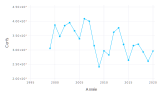

In [19]:
set_default_plot_size(16cm, 10cm)
df = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
plot(df, x=:Année, y=:Cerfs, Geom.line, Geom.point)

On peut voir que le lien entre l'année et le nombre de cerfs n'est pas linéaire. Confirmon cela en analysant le pouvoir prédictif de cette variable avec une régression linéaire. La courbe ressemble plutot à celle d'une fonction x +x2 +x3 +x4 ou une bimodale. Nous allons donc analyser si ces options semble avoir un pouvoir prédictif significatif.

#### 2.1.1 Ajout de l'année au carré, au cube et exposant 4 dans la matrice de données

In [20]:
Matrice = transform(Matrice, ["Année"] => ByRow(x->(x)^2) => :Année_square)
Matrice = transform(Matrice, ["Année"] => ByRow(x->(x)^3) => :Année_cubic)
Matrice = transform(Matrice, ["Année"] => ByRow(x->(x)^4) => :Année_four)

22×19 DataFrame
 Row │ Année  Cerfs  Température  Pluie_totale  Neige_totale  Neige_totale_au_ ⋯
     │ Int64  Int64  Float64      Float64       Float64       Int64            ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1999  30587      279.367         139.7           5.1                   ⋯
   2 │  2000  38737      278.813          79.9           9.6
   3 │  2001  34751      280.598         155.9           4.6
   4 │  2002  38501      276.943         108.9          63.3
   5 │  2003  39544      278.477         287.4           2.8                   ⋯
   6 │  2004  36699      278.641         122.6           0.4
   7 │  2005  33913      279.539         279.8          13.6
   8 │  2006  40908      279.195         250.8           0.0
   9 │  2007  40047      279.287         162.0          29.0                   ⋯
  10 │  2008  31513      278.295         156.6          15.6
  11 │  2009  24141      278.705         161.0           6.4
  12 │  2010  29738      278.425         206.0           5.6
  13 │  2011  28284      280.636         142.6           8.2                   ⋯
  14 │  2012  36220      278.754         108.0           1.0
  15 │  2013  37739        0.0             0.0           0.0
  16 │  2014  31953      279.464         120.2          17.2
  17 │  2015  26458      279.105         146.6           3.2                   ⋯
  18 │  2016  31531      279.875         209.4          10.0
  19 │  2017  32039      279.964         202.4           6.0
  20 │  2018  29331      276.113         154.4          44.0
  21 │  2019  26091      277.289         294.4          31.6                   ⋯
  22 │  2020  29661      279.649         150.4          22.4
                                                              14 columns omitted

#### 2.1.1 Pouvoir prédictif de l'année au global

Dans cette partie, nous allons regarder si l'année possède bel et bien un pouvoir prédictif significatif

In [26]:
lm(@formula(Cerfs ~ Année), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                    Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)     8.59895e5    2.85374e5   3.01    0.0069     2.64615e5     1.45517e6
Année        -411.439      142.012      -2.90    0.0089  -707.67       -115.208
───────────────────────────────────────────────────────────────────────────────────

In [31]:
lm(@formula(Cerfs ~ Année + Année_square), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année + Année_square

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)     0.0       NaN          NaN       NaN     NaN         NaN
Année         444.616     141.984        3.13    0.0053  148.443     740.789
Année_square   -0.213056    0.0706545   -3.02    0.0068   -0.360438   -0.065673
───────────────────────────────────────────────────────────────────────────────

In [32]:
lm(@formula(Cerfs ~ Année + Année_square + Année_cubic), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année + Année_square + Année_cubic

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                     Coef.    Std. Error       t  Pr(>|t|)      Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)    0.0          NaN           NaN       NaN     NaN            NaN
Année          0.0          NaN           NaN       NaN     NaN            NaN
Année_square   0.229564       0.0706421     3.25    0.0040    0.0822076      0.376921
Année_cubic   -0.000110157    3.51525e-5   -3.13    0.0052   -0.000183484   -3.68305e-5
───────────────────────────────────────────────────────────────────────────────────────

In [30]:
lm(@formula(Cerfs ~ Année + Année_square + Année_cubic + Année_four), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Année + Année_square + Année_cubic + Année_four

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                     Coef.    Std. Error       t  Pr(>|t|)     Lower 95%      Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)    0.0          NaN           NaN       NaN     NaN           NaN
Année          0.0          NaN           NaN       NaN     NaN           NaN
Année_square   0.0          NaN           NaN       NaN     NaN           NaN
Année_cubic    0.000118372    3.5147e-5     3.37    0.0031    4.50564e-5    0.000191687
Année_four    -5.6874e-8      1.74893e-8   -3.25    0.0040   -9.33561e-8   -2.0392e-8
──────────────────────────────────────────────────────────────────────────

Selon ces résultats, on peut constater que l'intervalle de confiance du coefficient sur l'année se situe bel et bien en dehors de 0, donc l'année possède un pouvoir prédictif significatif sur le nombre de cerfs. 

#### 2.1.2 Pouvoir prédictif de l'année par zone

In [46]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année), groupby(new_df, :Zone)[i])
    push!(models, r2(m))
end

results = DataFrame(Zone=zones, R2 = models)
sort(results, order(:R2, rev=true))

19×2 DataFrame
 Row │ Zone   R2         
     │ Int64  Any        
─────┼───────────────────
   1 │    28  0.757522
   2 │    12  0.651667
   3 │    21  0.592505
   4 │    11  0.526023
   5 │    10  0.429206
   6 │    20  0.410849
   7 │    27  0.38552
   8 │     3  0.350176
   9 │     8  0.316919
  10 │    26  0.22424
  11 │     9  0.200356
  12 │     7  0.19584
  13 │     5  0.174042
  14 │    13  0.165027
  15 │    15  0.103115
  16 │     1  0.0437057
  17 │     2  0.0257384
  18 │     4  0.00322799
  19 │     6  0.00267265

Comme on peut le voir, l'année a une très grande influence sur certaines zones comme la zone 28, et une influence quasi nulle sur des zones comme les zones 2, 4 et 6

#### 2.1.3 Pouvoir prédictif de l'année par zone: fonction polynomiales

Fonction polynomiale de degré 2:

In [41]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année + Année^2), groupby(new_df, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

19×2 DataFrame
 Row │ Zone   R2_ajusté   
     │ Int64  Any         
─────┼────────────────────
   1 │    28  0.636603
   2 │    12  0.635072
   3 │    21  0.564525
   4 │    11  0.502835
   5 │    10  0.400743
   6 │    20  0.382777
   7 │    27  0.34255
   8 │     3  0.318058
   9 │     8  0.282137
  10 │     9  0.161175
  11 │     7  0.155371
  12 │     5  0.131676
  13 │    13  0.120579
  14 │    26  0.0691944
  15 │    15  0.0509625
  16 │     1  -0.00991884
  17 │     2  -0.0278095
  18 │     4  -0.0465991
  19 │     6  -0.0474542

Fonction polynomiale de degré 3:

In [43]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année + Année^2 + Année^3), groupby(new_df, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

19×2 DataFrame
 Row │ Zone   R2_ajusté  
     │ Int64  Any        
─────┼───────────────────
   1 │    28  0.636923
   2 │    12  0.635897
   3 │    21  0.563716
   4 │    11  0.503345
   5 │    10  0.400809
   6 │    20  0.384175
   7 │    27  0.343466
   8 │     3  0.318432
   9 │     8  0.281523
  10 │     9  0.161945
  11 │     7  0.155095
  12 │     5  0.130576
  13 │    13  0.120066
  14 │    26  0.0692984
  15 │    15  0.0515793
  16 │     1  -0.0104025
  17 │     2  -0.0272036
  18 │     4  -0.0465856
  19 │     6  -0.0477919

Fonction polynomiale de degré 4:

In [42]:
models = []

z1 = DataFrame(groupby(new_df, :Zone))
    
zones = unique(new_df[!, :Zone])

models = []
for i = 1:length(zones)
    m = lm(@formula(Cerfs ~ Année + Année^2 + Année^3 + Année^4), groupby(new_df, :Zone)[i])
    push!(models, adjr2(m))
end

results = DataFrame(Zone=zones, R2_ajusté = models)
sort(results, order(:R2_ajusté, rev=true))

19×2 DataFrame
 Row │ Zone   R2_ajusté  
     │ Int64  Any        
─────┼───────────────────
   1 │    28  0.637242
   2 │    12  0.636722
   3 │    21  0.562913
   4 │    11  0.503852
   5 │    10  0.400864
   6 │    20  0.385584
   7 │    27  0.344378
   8 │     3  0.318807
   9 │     8  0.280922
  10 │     9  0.162681
  11 │     7  0.154802
  12 │     5  0.129445
  13 │    13  0.119543
  14 │    26  0.0693994
  15 │    15  0.0522077
  16 │     1  -0.0108728
  17 │     2  -0.0265695
  18 │     4  -0.0465702
  19 │     6  -0.0482071

Comme on peut le voir, les fonctions polynomiale de l'année voit leur infulences augmenter jusqu'au degré 4 et ce pour toutes les zones. En effet, leur placements ne changent pas. De ce fait, explorer des modèles polynomiales pour l'année pourrait etre interessant.

### 2.2 Tracer le nombre de cerfs récoltés par chaque arme individuellement

Nous avons remarqué que les cerfs sont récoltés via divers types d'armes récurents à chaque année. De ce fait, explorons un peu comments le nombre de cerfs récoltés évolue selon le type d'arme.

#### 2.2.1 Traçage du nombre de cerfs récoltés par arme globalement

Premièrement, il faudrait tracer le nombre de cerfs récoltés selon chaque arme de chasse utilisée.

In [49]:
combine(groupby(recolte, [:Engin]), :Cerfs => sum => :Cerfs)

6×2 DataFrame
 Row │ Engin        Cerfs  
     │ String15     Int64  
─────┼─────────────────────
   1 │ Arc           29408
   2 │ Carabine     542712
   3 │ Indéterminé      32
   4 │ ACB           61715
   5 │ Arbalète      65498
   6 │ Fusil         29021

Comme on peut le voir, on a 6 types d'armes à vérifier. On peut alors affirmer que 

Y = Y1 + Y2 + Y3 + Y4 + Y5 + Y6
,ou Y est le nombre de cerfs et Yi représente un type d'arme.

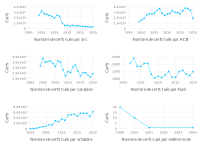

In [50]:
df_armes = combine(groupby(recolte, [:Année, :Engin]), :Cerfs => sum => :Cerfs)
df_arc = filter(row -> !(row.Engin != "Arc"),  df_armes)
df_carabine = filter(row -> !(row.Engin != "Carabine"),  df_armes)
df_arbalète = filter(row -> !(row.Engin != "Arbalète"),  df_armes)
df_acb = filter(row -> !(row.Engin != "ACB"),  df_armes)
df_fusil = filter(row -> !(row.Engin != "Fusil"),  df_armes)
df_indetermine = filter(row -> !(row.Engin != "Indéterminé"),  df_armes)


p1 = plot(df_arc, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arc"))
p2 = plot(df_carabine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par carabine"))
p3 = plot(df_arbalète, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arbalète"))
p4 = plot(df_acb, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par ACB"))
p5 = plot(df_fusil, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Fusil"))
p6 = plot(df_indetermine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Indéterminé"))
                        
p = reshape(Plot[p1, p2, p3, p4, p5, p6], (3,2))
    
set_default_plot_size(20cm, 15cm)
gridstack(p)

#### 2.2.2 Traçage du nombre de cerfs récoltés par zone

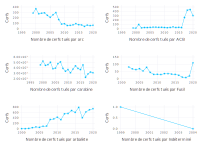

In [52]:
zone = 6 #On regarde la zone 6 par exemple

df_armes = combine(groupby(recolte, [:Année, :Engin, :Zone]), :Cerfs => sum => :Cerfs)
df_arc = filter(row -> !(row.Engin != "Arc") && row.Zone == zone,  df_armes)
df_carabine = filter(row -> !(row.Engin != "Carabine") && row.Zone == zone,  df_armes)
df_arbalète = filter(row -> !(row.Engin != "Arbalète") && row.Zone == zone,  df_armes)
df_acb = filter(row -> !(row.Engin != "ACB") && row.Zone == zone,  df_armes)
df_fusil = filter(row -> !(row.Engin != "Fusil") && row.Zone == zone,  df_armes)
df_indetermine = filter(row -> !(row.Engin != "Indéterminé") && row.Zone == zone,  df_armes)


p1 = plot(df_arc, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arc"))
p2 = plot(df_carabine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par carabine"))
p3 = plot(df_arbalète, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par arbalète"))
p4 = plot(df_acb, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par ACB"))
p5 = plot(df_fusil, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Fusil"))
p6 = plot(df_indetermine, x=:Année, y=:Cerfs, Geom.line, Geom.point, Guide.xlabel("Nombre de cerfs tués par Indéterminé"))
                        
p = reshape(Plot[p1, p2, p3, p4, p5, p6], (3,2))
set_default_plot_size(20cm, 15cm)
gridstack(p)

### 2.3 Utilisation du nombre de permis comme variable explicative

Deuxièmement, voici un graphique qui illustre le nombre de cerfs récoltés en fonction de toutes les variables dans le dataset (permis). Comme on peut le voir certaines valeurs semblent avoir des impacts plus significatifs que d'autres, nous allons tenter de voir quelle variables nous devrions garder

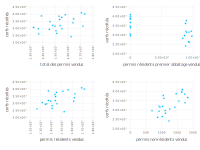

In [53]:
df = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
df2 = innerjoin(df, permis, on = :Année)



p1 = plot(df2, x=:Total, y=:Cerfs, Geom.point,
     Guide.xlabel("total des permis vendus"),
     Guide.ylabel("cerfs récoltés"))

p2 = plot(df2, x=:"Résidents", y=:Cerfs, Geom.point,
     Guide.xlabel("permis résidents vendus"),
     Guide.ylabel("cerfs récoltés"))

p3 = plot(df2, x=:"Résidents premier abbatage", y=:Cerfs, Geom.point,
     Guide.xlabel("permis résidents premier abbatage vendus"),
     Guide.ylabel("cerfs récoltés"))

p4 = plot(df2, x=:"Non-résidents", y=:Cerfs, Geom.point,
     Guide.xlabel("permis non-résidents vendus"),
     Guide.ylabel("cerfs récoltés"))

p = reshape(Plot[p1, p2, p3, p4], (2,2))
    
set_default_plot_size(20cm, 15cm)
gridstack(p)

#### 2.3.1 Pouvoir prédictif du nombre de permis total émis

In [54]:
lm(@formula(Cerfs ~ Total), df2)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Total

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                   Coef.     Std. Error     t  Pr(>|t|)       Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)  8700.73      13581.9        0.64    0.5290  -19630.7        37032.2
Total           0.159378      0.0884491  1.80    0.0867      -0.0251233      0.34388
────────────────────────────────────────────────────────────────────────────────────

> Comme on peut le voir, cette variable ne semble pas posséder de pouvoir prédictif significatif pour un seil de 95% puisque zéro est inclu dans son intervalle de confiance.

#### 2.3.2 Pouvoir prédictif du nombre de permis résidents émis

In [55]:
lm(@formula(Cerfs ~ Résidents), df2)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Résidents

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                 Coef.     Std. Error     t  Pr(>|t|)       Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)  613.913    10823.0        0.06    0.9553  -21962.4        23190.2
Résidents      0.22117      0.0734153  3.01    0.0069       0.0680282      0.374311
───────────────────────────────────────────────────────────────────────────────────

> Comme on peut le voir, cette variable semble posséder un pouvoir prédictif significatif, car zéro n'est pas inclu dans son intervalle de confiance.

#### 2.3.3 Pouvoir prédictif du nombre de permis non-résidents émis

In [56]:
df2.nonres = df2[!, "Non-résidents"]
lm(@formula(Cerfs ~ nonres), df2)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + nonres

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error     t  Pr(>|t|)    Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  21028.0     3172.5      6.63    <1e-05  14410.3      27645.7
nonres           9.5248     2.41932  3.94    0.0008      4.47818     14.5714
────────────────────────────────────────────────────────────────────────────

> Comme on peut le voir, cette variable semble aussi posséder un pouvoir prédictif significatif.

#### 2.3.4 Pouvoir prédictif du nombre de permis permier abbatage

In [57]:
df2.premierabbatage = df2[!, "Résidents premier abbatage"]
df_premier_abbatage = filter(row -> row.premierabbatage != 0,  df2) #Enlever les missing
lm(@formula(Cerfs ~ premierabbatage), df_premier_abbatage)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + premierabbatage

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)      36873.3      26171.2       1.41    0.1892  -21439.7      95186.2
premierabbatage     -0.71058      2.87863  -0.25    0.8100      -7.12457      5.70341
─────────────────────────────────────────────────────────────────────────────────────

> Comme on peut le voir, cette variable ne semble pas posséder de pouvoir prédictif significatif.

#### Conclusion

On peut donc conclure que seuls les permis résidents ainsi que les permi-non-résidents ont une influence sur le nombre de cerfs récoltés par année. De ce fait, nous les utiliserons pour tester des modèles.

### 2.4 Utilisation de la température moyenne comme variable explicative

###### 2.4.1 Graphique du nombre de cerfs selon la température moyenne durant la période de chasse

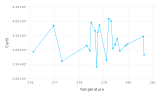

In [63]:
set_default_plot_size(16cm, 10cm)
#Nous enlevons 2013, car cette donnée était manquante pour les données de météo originaux.
plot(filter(row -> row.Année !== 2013,Matrice), x=:Température, y=:Cerfs, Geom.line, Geom.point)

Il ne semble pas y avoir un lien linéaire entre la température moyenne annuelle et le nombre de cerfs récoltés au total dans l'année. 

#### 2.4.2 Pouvoir prédictif de la température

Étant non linéaire, il se pourrait qu'une relation polynomiale puisse avoir un pouvoir prédictif significatif sur le nombre de cerfs récoltés annuellement. De ce fait, regardons à partir de quel modèle, zéro n'est pas inclu dans l'intervalle de confiance des coefficients.

In [116]:
lm(@formula(Cerfs ~ Température), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Température

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                Coef.    Std. Error     t  Pr(>|t|)      Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  4655.72      2.82413e5  0.02    0.9870     -5.86441e5     5.95753e5
Température   101.223  1012.55       0.10    0.9214  -2018.06       2220.51
────────────────────────────────────────────────────────────────────────────────

In [115]:
lm(@formula(Cerfs ~ Température + Température^2), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Température + :(Température ^ 2)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                       Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)        0.0         NaN        NaN       NaN       NaN         NaN
Température      139.463      1015.71       0.14    0.8922  -1986.43     2265.36
Température ^ 2   -0.0772542     3.64154   -0.02    0.9833     -7.69909     7.54459
───────────────────────────────────────────────────────────────────────────────────

In [114]:
lm(@formula(Cerfs ~ Température + Température^2 + Température^3), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Température + :(Température ^ 2) + :(Température ^ 3)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                       Coef.   Std. Error       t  Pr(>|t|)  Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)       0.0         NaN          NaN       NaN     NaN        NaN
Température       0.0         NaN          NaN       NaN     NaN        NaN
Température ^ 2   0.941621      3.6528       0.26    0.7993   -6.70378    8.58702
Température ^ 3  -0.00186023    0.0130958   -0.14    0.8885   -0.02927    0.0255495
───────────────────────────────────────────────────────────────────────────────────

On peut voir que zéro est toujours inclu dans l'intervalle de confiance des coefficient. De ce fait la température ne semble pas avoir un pouvoir prédictif significatif. Nous ne l'inclurons pas dans nos modèles de prédiction.

### 2.5 Utilisation de la quantité de pluie totale comme variable explicative

###### 2.5.1 Graphique du nombre de cerfs selon la quantité de pluie totale durant la période de chasse

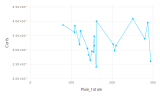

In [73]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Pluie_totale",y=:Cerfs, Geom.line, Geom.point)

Comme on peut le voir, il ne semble pas y avoir de relation linéaire ente la quantité de pluie et le nombre de cerfs. De ce fait nous verrons aussi le pouvoir prédictif des relations polynomiales.

###### 2.5.2 Pouvoir prédictif de la pluie

In [113]:
lm(@formula(Cerfs ~ Pluie_totale), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Pluie_totale

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   33416.9       3371.72     9.91    <1e-08  26359.8     40474.0
Pluie_totale     -3.05265     18.3904  -0.17    0.8699    -41.5443     35.439
─────────────────────────────────────────────────────────────────────────────

In [112]:
lm(@formula(Cerfs ~ Pluie_totale + Pluie_totale^2 ), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Pluie_totale + :(Pluie_totale ^ 2)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                         Coef.    Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)       50097.8       10514.0        4.76    0.0002  28008.6       72187.0
Pluie_totale       -194.47        116.177     -1.67    0.1114   -438.55         49.609
Pluie_totale ^ 2      0.490545      0.294296   1.67    0.1129     -0.127748      1.10884
────────────────────────────────────────────────────────────────────────────────────────

In [111]:
lm(@formula(Cerfs ~ Pluie_totale + Pluie_totale^2 + Pluie_totale^3 ), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Pluie_totale + :(Pluie_totale ^ 2) + :(Pluie_totale ^ 3)

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                         Coef.    Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         0.0         NaN           NaN       NaN     NaN           NaN
Pluie_totale      649.904        97.2651        6.68    <1e-05  445.558       854.25
Pluie_totale ^ 2   -3.96159       0.986954     -4.01    0.0008   -6.03511      -1.88808
Pluie_totale ^ 3    0.00737907    0.00232197    3.18    0.0052    0.00250079    0.0122574
─────────────────────────────────────────────────────────────────────────────────────────

Zéro n'est dans l'intervalle de confiance de la relation cubique. De ce fait, la pluie totale durant la période de chasse semble avoir un pouvoir prédictif significatif.

### 2.6 Utilisation de la quantité de neige totale comme variable explicative

###### 2.6.1 Graphique de la neige totale durant la période de chasse selon les années

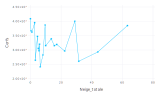

In [79]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Neige_totale", y=:Cerfs, Geom.line, Geom.point)

Ici aussi on ne voit pas de lien linéaire entre la neige totale durant la période de chasse annuelle et le nombre de cerfs récoltés. Cependant, cette courbe l'allure générale d'une parabole. De ce fait, ils serait intéressant d'utiliser un modèle quadratique pour estimer le nombre de cerfs.

###### 2.6.2 Pouvoir prédictif de la neige

In [110]:
lm(@formula(Cerfs ~ Neige_totale + Neige_totale^2), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Neige_totale + :(Neige_totale ^ 2)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)       34840.3      1856.07     18.77    <1e-12  30940.9      38739.8
Neige_totale       -323.342     205.422    -1.57    0.1329   -754.918      108.235
Neige_totale ^ 2      5.91723     3.50793   1.69    0.1089     -1.45265     13.2871
───────────────────────────────────────────────────────────────────────────────────

Zéro est inclu dans l'intervalle de confiance, ce qui impliquerait que la neige n'a pas un pouvoir prédictif significatif, nous allons tout de même garder le modèle quadratique du à son allure prononcé graphiquement.

### 2.7 Utilisation de la neige totale au sol comme variable explictive

###### 2.7.1 Graphique du nombre de cerfs récolté selon la neige totale au sol 

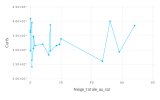

In [81]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Neige_totale_au_sol", y=:Cerfs, Geom.line, Geom.point)

Il n'y a pas de relation linéaire entre la quantité de neige au sol et le combre de cerfs récoltés durant la période de chasse. 
Cette courbe semble pouvoir etre approximé par une parabole. De ce fait, nous pourrons voir si une relation quadratique a un pouvoir significatif.

###### 2.7.2  Pouvoir prédictif de la neige totale au sol

In [109]:
lm(@formula(Cerfs ~ Neige_totale_au_sol), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Neige_totale_au_sol

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                         Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)          32594.8      1386.89   23.50    <1e-14  29692.0     35497.6
Neige_totale_au_sol     18.267      52.749   0.35    0.7329    -92.1379    128.672
──────────────────────────────────────────────────────────────────────────────────

In [108]:
lm(@formula(Cerfs ~ Neige_totale_au_sol + Neige_totale_au_sol^2), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Neige_totale_au_sol + :(Neige_totale_au_sol ^ 2)

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                               Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              33470.9      1647.2      20.32    <1e-13  30010.2      36931.5
Neige_totale_au_sol       -174.458     202.201    -0.86    0.3996   -599.268      250.351
Neige_totale_au_sol ^ 2      3.20665     3.24767   0.99    0.3365     -3.61645     10.0297
──────────────────────────────────────────────────────────────────────────────────────────

Pour tous ces modèles, zéro est inclu dans l'intervalle de confiance. De ce fait, la neige totale au sol ne semble pas avoir un effet prédictif significatif. Nous ne l'incluerons pas dans notre modèle de prédiction à plusieurs variables.

### 2.8 Utilisation du nombre de jours ayant de la neige au sol comme variable explicative

#### 2.8.1 Graphique du nombre de cerfs récoltés selon le nombre de jours ayant de la neige au sol

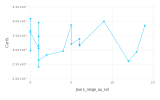

In [84]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Jours_neige_au_sol", y=:Cerfs, Geom.line, Geom.point)

La relation entre le nombre de jours ayant de la neige au sol et le nombre de cerfs n'est pas linéaire. Cependant, cette courbe resemble un peu a celle d'une relation cubic. Nous explorons alors le pouvoir prédictif des relations polynomiales.

#### 2.8.2 Pouvoir prédictif du nombre de jours ayant de la neige au sol

In [107]:
lm(@formula(Cerfs ~ Jours_neige_au_sol), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_neige_au_sol

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)         32886.3       1523.07   21.59    <1e-14  29698.5    36074.1
Jours_neige_au_sol      0.3953     250.876   0.00    0.9988   -524.694    525.485
─────────────────────────────────────────────────────────────────────────────────

In [106]:
lm(@formula(Cerfs ~ Jours_neige_au_sol + Jours_neige_au_sol^2), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_neige_au_sol + :(Jours_neige_au_sol ^ 2)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────
                            Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────────
(Intercept)             33139.8     1890.87    17.53    <1e-12  29167.2    37112.4
Jours_neige_au_sol       -197.769    871.42    -0.23    0.8230  -2028.55    1633.02
Jours_neige_au_sol ^ 2     15.652     65.7592   0.24    0.8146   -122.503    153.807
────────────────────────────────────────────────────────────────────────────────────

In [105]:
lm(@formula(Cerfs ~ Jours_neige_au_sol + Jours_neige_au_sol^2 + Jours_neige_au_sol^3), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_neige_au_sol + :(Jours_neige_au_sol ^ 2) + :(Jours_neige_au_sol ^ 3)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)             33884.9      2227.13    15.21    <1e-10  29186.1     38583.7
Jours_neige_au_sol      -1591.39     2285.76    -0.70    0.4957  -6413.93     3231.15
Jours_neige_au_sol ^ 2    325.814     473.739    0.69    0.5009   -673.689    1325.32
Jours_neige_au_sol ^ 3    -15.8913     24.0296  -0.66    0.5173    -66.5894     34.8068
───────────────────────────────────────────────────────────────────────────────────────

Zéro est toujours inclu dans l'intervalle de confiance de ces trois relations, de ce fait le nombre de jours de neige au sol ne semble pas avoir un pouvoir prédictif significatif. Nous n'incluronts pas non plus cette variable dans notre modèle de prédiction à plusieurs variables.

### 2.9 Utilisation du nombre de jours de neige comme variable explicative

#### 2.9.1 Graphique du nombre de cerfs récoltés selon le nombre de jours de neige

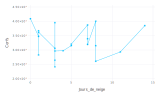

In [88]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Jours_de_neige", y=:Cerfs, Geom.line, Geom.point)

Cette relation entre le nombre de jours ayant de la neige au sol et le nombre de cerfs n'est pas linéaire. Cependant, cette courbe resemble un peu a celle d'une relation Y = x + x2 + x3 +x4. Nous explorons alors le pouvoir prédictif des relations polynomiales.

###### 2.9.2 Pouvoir prédictif du nombre de jours de neiges par année

In [104]:
lm(@formula(Cerfs ~ Jours_de_neige), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_de_neige

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)     32674.8       1875.95   17.42    <1e-12  28748.3    36601.2
Jours_de_neige     43.4669     309.602   0.14    0.8898   -604.538    691.472
─────────────────────────────────────────────────────────────────────────────

In [103]:
lm(@formula(Cerfs ~ Jours_de_neige +  Jours_de_neige^2), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_de_neige + :(Jours_de_neige ^ 2)

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)         35283.5     2483.74    14.21    <1e-10  30065.4     40501.7
Jours_de_neige      -1289.11     917.68    -1.40    0.1771  -3217.09      638.862
Jours_de_neige ^ 2    106.967     69.6404   1.54    0.1419    -39.3424    253.276
─────────────────────────────────────────────────────────────────────────────────

In [102]:
lm(@formula(Cerfs ~ Jours_de_neige +  Jours_de_neige^2 +  Jours_de_neige^3), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_de_neige + :(Jours_de_neige ^ 2) + :(Jours_de_neige ^ 3)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                         Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)         37424.2      3269.13    11.45    <1e-08  30526.9     44321.5
Jours_de_neige      -3395.21     2284.61    -1.49    0.1556  -8215.32     1424.9
Jours_de_neige ^ 2    508.641     405.079    1.26    0.2262   -346.0      1363.28
Jours_de_neige ^ 3    -19.4159     19.2891  -1.01    0.3283    -60.1123     21.2806
───────────────────────────────────────────────────────────────────────────────────

In [101]:
lm(@formula(Cerfs ~ Jours_de_neige +  Jours_de_neige^2 +  Jours_de_neige^3 +  Jours_de_neige^4), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_de_neige + :(Jours_de_neige ^ 2) + :(Jours_de_neige ^ 3) + :(Jours_de_neige ^ 4)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error      t  Pr(>|t|)       Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)          41365.5       3504.81   11.80    <1e-08   33935.6        48795.4
Jours_de_neige      -10313.5       3859.82   -2.67    0.0167  -18495.9        -2131.0
Jours_de_neige ^ 2    3057.82      1253.69    2.44    0.0268     400.12        5715.53
Jours_de_neige ^ 3    -330.238      147.155  -2.24    0.0393    -642.192        -18.2828
Jours_de_neige ^ 4      11.6709       5.486   2.13    0.0493       0.0410991     23.3007
───

Puisque zéro n'est pas inclu dans l'intervalle de confiance de la derniere relation, il y a donc un pouvoir prédictif significatif pour celui-ci.

### 2.10 Utilisation du nombre de jours de pluie

###### 2.10.1 Graphique du nombre de cerfs récoltés selon le nombre de jours de pluie

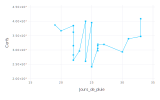

In [94]:
set_default_plot_size(16cm, 10cm)
plot(filter(row -> row.Année !== 2013, Matrice), x=:"Jours_de_pluie", y=:Cerfs, Geom.line, Geom.point)

Ce graphique resemble à une parabole, de ce fait il se pourait que la relation soit quadratique. Nous explorerons le pouvoir prédictif de cette posibilité.

###### 2.10.2 Pouvoir prédictif du nombre de jours de pluie

In [99]:
lm(@formula(Cerfs ~ Jours_de_pluie), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_de_pluie

Coefficients:
────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)     31239.0       7302.06   4.28    0.0004  15955.6    46522.4
Jours_de_pluie     65.5833     287.105  0.23    0.8218   -535.335    666.501
────────────────────────────────────────────────────────────────────────────

In [98]:
lm(@formula(Cerfs ~ Jours_de_pluie + Jours_de_pluie^2), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_de_pluie + :(Jours_de_pluie ^ 2)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                            Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)             1.25228e5  41986.6      2.98    0.0080   37017.0     213438.0
Jours_de_pluie      -7232.3         3229.87    -2.24    0.0380  -14018.0       -446.599
Jours_de_pluie ^ 2    138.363         61.0372   2.27    0.0360      10.1287     266.598
───────────────────────────────────────────────────────────────────────────────────────

In [100]:
lm(@formula(Cerfs ~ Jours_de_pluie + Jours_de_pluie^2 + Jours_de_pluie^3), filter(row -> row.Année !== 2013, Matrice))

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Jours_de_pluie + :(Jours_de_pluie ^ 2) + :(Jours_de_pluie ^ 3)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.     Std. Error      t  Pr(>|t|)       Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         126555.0            3.07411e5   0.41    0.6857      -5.22025e5  775135.0
Jours_de_pluie       -7390.55       36434.6        -0.20    0.8417  -84260.8         69479.7
Jours_de_pluie ^ 2     144.548       1419.51        0.10    0.9201   -2850.35         3139.45
Jours_de_pluie ^ 3      -0.0792048     18.1602     -0.00    0.9966     -38.3938         38.2354
───────────────────────────────────────────────────────────────────

On peut voir que seul le modèle quadratique n'inclue pas dans l'intervalle de confiance. Alors, il se pourrait que le nombre de jours de pluie ait un pouvoir prédictif significatif sur le nombre de cerfs récoltés.

### 2.11 Utilisation du prix moyen de l'essence à Montréal comme variable explicative

###### 2.11.1 Graphique du nombre de cerfs récoltés selon le prix moyen de l'essence à Montréal

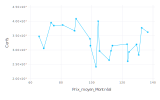

In [117]:
set_default_plot_size(16cm, 10cm)
plot(Matrice, x=:"Prix_moyen_Montréal", y=:Cerfs, Geom.line, Geom.point)

Cette relation n'est pas inéaire. En effet, la courbe a plutot l'allure d'une relation cubique. Nous explorerons le pouvoir prédictif des relations polynomiales avec cette variable explicative.

###### 2.11.2 Pouvoir prédictif du prix moyen de l'essence à Montréal

In [118]:
lm(@formula(Cerfs ~ Prix_moyen_Montréal), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Montréal

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)          41969.6      4929.58     8.51    <1e-07  31686.7    52252.5
Prix_moyen_Montréal    -85.1031     46.3732  -1.84    0.0814   -181.836     11.6297
───────────────────────────────────────────────────────────────────────────────────

In [119]:
lm(@formula(Cerfs ~ Prix_moyen_Montréal + Prix_moyen_Montréal^2 ), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Montréal + :(Prix_moyen_Montréal ^ 2)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                               Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              62076.3      23816.2       2.61    0.0173  12228.4        1.11924e5
Prix_moyen_Montréal       -500.89       483.947    -1.04    0.3137  -1513.8      512.024
Prix_moyen_Montréal ^ 2      2.05184      2.37707   0.86    0.3988     -2.92343    7.02711
────────────────────────────────────────────────────────────────────────────────────────────

In [120]:
lm(@formula(Cerfs ~ Prix_moyen_Montréal + Prix_moyen_Montréal^2 + Prix_moyen_Montréal^3 ), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Montréal + :(Prix_moyen_Montréal ^ 2) + :(Prix_moyen_Montréal ^ 3)

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────
                                Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                 0.0        NaN          NaN       NaN      NaN           NaN
Prix_moyen_Montréal      1552.99       251.214        6.18    <1e-05  1027.19       2078.78
Prix_moyen_Montréal ^ 2   -19.7747       4.85658     -4.07    0.0007   -29.9396       -9.60974
Prix_moyen_Montréal ^ 3     0.0747362    0.0229165    3.26    0.0041     0.0267715     0.122701
────────────────────────────────────────────────────────

Comme nous l'avions prédis, zéro n'est pas inclu dans l'intervalle de confiance pour le modèle cubique, alors il pourrait y avoir un pouvoir prédictif significatif.

### 2.12 Utilisation du prix moyen de l'essence à Québec comme variable explicative

###### 2.12.1 Graphique du nombre de cerfs récoltés selon le prix moyen de l'essence à Montréal

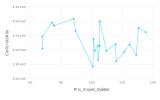

In [121]:
set_default_plot_size(16cm, 10cm)
plot(Matrice, x=:"Prix_moyen_Québec", y=Matrice.Cerfs, Geom.line, Geom.point, Guide.ylabel("Cerfs récoltés"))

Tout comme le prix de l'essence a Montréal, cette relation n'est pas linéaire. La courbe a plutot l'allure d'une relation polynomiale de degré 3. Nous explorerons, donc, le pouvoir prédictif de ces relations.

###### 2.12.2 Pouvoir prédictif du prix moyen de l'essence à Québec

In [122]:
lm(@formula(Cerfs ~ Prix_moyen_Québec), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Québec

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)        41350.0      5225.71     7.91    <1e-06  30449.3    52250.6
Prix_moyen_Québec    -80.8387     50.2907  -1.61    0.1236   -185.743     24.0659
─────────────────────────────────────────────────────────────────────────────────

In [123]:
lm(@formula(Cerfs ~ Prix_moyen_Québec + Prix_moyen_Québec^2 ), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Québec + :(Prix_moyen_Québec ^ 2)

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            70246.8      24396.1       2.88    0.0096  19185.2        1.21309e5
Prix_moyen_Québec       -684.499      500.559    -1.37    0.1874  -1732.18     363.182
Prix_moyen_Québec ^ 2      3.02355      2.49475   1.21    0.2404     -2.19803    8.24513
──────────────────────────────────────────────────────────────────────────────────────────

In [124]:
lm(@formula(Cerfs ~ Prix_moyen_Québec + Prix_moyen_Québec^2 + Prix_moyen_Québec^3 ), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Québec + :(Prix_moyen_Québec ^ 2) + :(Prix_moyen_Québec ^ 3)

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                              Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)               0.0        NaN          NaN       NaN      NaN           NaN
Prix_moyen_Québec      1596.5        254.918        6.26    <1e-05  1062.95       2130.05
Prix_moyen_Québec ^ 2   -20.8608       4.96468     -4.20    0.0005   -31.252       -10.4696
Prix_moyen_Québec ^ 3     0.0809234    0.0237034    3.41    0.0029     0.0313116     0.130535
─────────────────────────────────────────────────────────────────────────────

Encore une fois, comme nous l'avions prédis, c'est la relation polynomiale de degré 3 qui a un pouvoir prédictif significatif.

### 2.13 Utilisation du prix moyen de l'essence entre Montréal et Québec comme variable explicative

###### 2.13.1 Graphique du nombre de cerfs récoltés selon le prix moyen de l'essence à Montréal

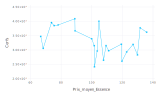

In [125]:
set_default_plot_size(16cm, 10cm)
plot(Matrice, x=:"Prix_moyen_Essence", y=:Cerfs, Geom.line, Geom.point)

Comme pour le prix de Montréal et de Québec, la relation n'est pas linéaire, mais a plutot l'allure d'une courbe polynomiale de degré 3. Nous confirmerons ceci, en analysant le pouvoir prédictif de celle-ci.

###### 2.13.2 Pouvoir prédictif du prix moyen de l'essence

In [126]:
lm(@formula(Cerfs ~ Prix_moyen_Essence), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Essence

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)         41732.3       5085.87    8.21    <1e-07  31123.3    52341.2
Prix_moyen_Essence    -83.6968      48.394  -1.73    0.0991   -184.645     17.2513
──────────────────────────────────────────────────────────────────────────────────

In [127]:
lm(@formula(Cerfs ~ Prix_moyen_Essence +  Prix_moyen_Essence^2), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Essence + :(Prix_moyen_Essence ^ 2)

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                              Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             66417.5      24175.8       2.75    0.0128  15817.1      117018.0
Prix_moyen_Essence       -596.774      493.661    -1.21    0.2415  -1630.02        436.471
Prix_moyen_Essence ^ 2      2.55152      2.44319   1.04    0.3094     -2.56214       7.66518
────────────────────────────────────────────────────────────────────────────────────────────

In [128]:
lm(@formula(Cerfs ~ Prix_moyen_Essence +  Prix_moyen_Essence^2 + Prix_moyen_Essence^3), Matrice)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Cerfs ~ 1 + Prix_moyen_Essence + :(Prix_moyen_Essence ^ 2) + :(Prix_moyen_Essence ^ 3)

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────
                               Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                0.0        NaN          NaN       NaN      NaN           NaN
Prix_moyen_Essence      1577.76       252.503        6.25    <1e-05  1049.26       2106.25
Prix_moyen_Essence ^ 2   -20.3685       4.89905     -4.16    0.0005   -30.6223      -10.1146
Prix_moyen_Essence ^ 3     0.0780328    0.0232583    3.36    0.0033     0.0293526     0.126713
───────────────────────────────────────────────────────────────────

Encore une fois, zéro n'est pas inclu dans l'intervalle de confiance de la derniere relation, donc il se pourrait que le prix moyen de l'essence ait un pouvoir prédictif significatif.

### 2.14 Conclusion de l'analyse exploratoire

Suite à cette analyse du pouvoir prédictif significatif des variables explicatives, voici celles qui seront utilisés dans nos prochains modèles de prédiction du nombre de cerfs récoltés dans les zones  pour les modeles de régression multiple et les modeles polynomiales:

Régression multiple:
1. Année
2. Type d'armes
3. Permis résident
4. Permis non-résidents
5. Prix de l'essence Mtl
6. Prix de l'essence Qc
7. Prix de l'essence 

Régression polynomiale:
1. Année (jusqu'a degré 4)
2. Pluie totale (degré 3)
3. Jours de neige (degré 4)
4. Jours de pluie (degré 2)
5. Prix de l'essence Mtl (degré 3)
6. Prix de l'essence Qc (degré 3)
7. Prix de l'essence (degré 3)

## 3. Estimation du nombre de permis en 2021

Comme on peut le voir, le nombre de permis émis en 2021 n'est pas fourni, nous allons donc tenter de l'estimer, comme nous avons vu précédemment, seuls le nombre de permis résidents et non-résidents nous intéressent, alors nous n'allons estimer que ces valeurs

#### 3.1 Permis résidents

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(permis, x=:Année, y=:Résidents, Geom.line, Geom.point,
    Guide.ylabel("Permis résidents vendus"))

In [ ]:
n = size(permis, 1)
Y = [permis[i, :Résidents] for i in 1:n-1]
X = hcat(ones(n - 1), [permis[i, :Année] for i in 1:n-1], [permis[i, :Année]^2 for i in 1:n-1])

B = X \ Y

permis_residents_2021 = ceil(B[1] + B[2] * 2021 + B[3] * 2021^2)

Nous allons utiliser cette estimation plus tard

In [ ]:
obs = layer(permis, x=:Année, y=:Résidents, Geom.point)
model = layer(x-> B[1] + B[2] * x + B[3] * x^2, 1998, 2021, Theme(default_color="red"))

set_default_plot_size(16cm, 10cm)
plot(obs, model)

#### 3.2 Permis non-résidents

In [ ]:
set_default_plot_size(16cm, 10cm)
plot(permis, x=:Année, y=:"Non-résidents", Geom.line, Geom.point,
    Guide.ylabel("Permis non-résidents vendus"))

In [ ]:
n = size(permis, 1)
Y = [permis[i, :"Non-résidents"] for i in 1:n-1]
X = hcat(ones(n - 1), [permis[i, :Année] for i in 1:n-1], [permis[i, :Année]^2 for i in 1:n-1])

B = X \ Y

permis_residents_2021 = ceil(B[1] + B[2] * 2021 + B[3] * 2021^2)

Nous allons utiliser cette estimation plus tard

In [ ]:
obs = layer(permis, x=:Année, y=:"Non-résidents", Geom.point)
model = layer(x-> B[1] + B[2] * x + B[3] * x^2, 1998, 2021, Theme(default_color="red"))

set_default_plot_size(16cm, 10cm)
plot(obs, model)

In [61]:
Pluie2021 = PluieAn.Pluie_totale[22]
Neige2021 = NeigeAn.Neige_totale[22]
NeigeTS2021 = NeigeSolAn.Neige_totale_au_sol[22]
JPluie2021 = JourPluieAn.Jours_de_pluie[22] 
JNeige2021 = JourNeigeAn.Jours_de_neige[22]
JNeigeS2021 = JourNeigeSolAn.Jours_neige_au_sol[22] 
PrixMtl2021 = essenceMtlMoyAn.Prix_moyen_Montréal[25] 
PrixQc2021 = essenceQcMoyAn.Prix_moyen_Québec[25]
PrixEssence2021 = essenceMoyAn.Prix_moyen_Essence[25]
Temp2021

280.13278688524593

## 4. Modèles de régressions linéaires

Dans cette section, nous allons tenter de créer des modèles de régression linéaire et de les ordonner du meilleur au pire selon nos prédictions

### 4.1 Modèles sans transformation de la variable d'intérêt (pas de catégorisation d'armes)

#### 4.1.1 Tenter de classer nos modèles selon le R2 (avec années et permis comme variables explicatives)

In [ ]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Année2= Int64[], Zone = Int64[], Cerfs= Int64[], Résidents= Int64[], NonRes= Int64[], Essence= Float64[], Essence2= Float64[], Essence3= Float64[], Temperature3= Float64[], Jour_de_Pluie= Int64[], Jour_de_Pluie2= Int64[])

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)
    df = innerjoin(df, Matrice, on = :Année) 
    
    df2 = DataFrame(Année = df.Année,
                    Année2 = [df.Année[i]^2 for i in 1:size(df.Année, 1)],
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs,
                    Résidents = df.Résidents,
                    NonRes = df."Non-résidents",
                    Essence = df.Prix_moyen_Essence,
                    Essence2 = [df.Prix_moyen_Essence[i]^2 for i in 1:size(df.Année, 1)], 
                    Essence3 = [df.Prix_moyen_Essence[i]^3 for i in 1:size(df.Année, 1)], 
                    Temperature3 = [df.Température[i]^3 for i in 1:size(df.Année, 1)],
                    Jour_de_Pluie = df.Jours_de_pluie,
                    Jour_de_Pluie2 = [df.Jours_de_pluie[i]^2 for i in 1:size(df.Année, 1)]) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end



sort!(new_df, :Année)
first(new_df, 5)

In [ ]:
zones = unique(new_df[!, :Zone])

models = DataFrame(Zone= Int64[], R2= Float64[], Formula= Any[], Prediction= Float64[])
for i = 1:length(zones)
    modelsZone = DataFrame(R2= Float64[], Formula= Any[], Prediction= Int64[])
    
    for termes in combinations([:Année, :Résidents, :NonRes])
        formula = term(:Cerfs) ~ sum(term.(termes))
        m = lm(formula, groupby(new_df, :Zone)[i])
        pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[117278], NonRes=[508], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
        push!(modelsZone, [r2(m), formula, pred])
    end
    sorted_models = sort(modelsZone, :R2, rev=true)
    
    push!(models, [groupby(new_df, :Zone)[i].Zone[1], sorted_models.R2[1], sorted_models.Formula[1], sorted_models.Prediction[1]])
end

models

In [ ]:
test = CSV.read("data/test.csv", DataFrame);

models = models[in.(models.Zone, Ref(test.Zone)), :]
n = size(models, 1)
prediction = DataFrame(Zone = models.Zone, Cerfs = [Int64((models.Prediction[i])) for i in 1:n])
CSV.write("simple_regression_r2.csv", prediction)

Cette régression possède un rmse assez mauvais quand nous l'avons soumis sur Kaggle, nous allons donc tenter d'évaluer nos modèles d'une autre manière

#### 4.1.2 Tenter de classer nos modèles selon les RMSE (avec années et permis comme variables explicatives)

In [ ]:
zones = unique(new_df[!, :Zone])

models = DataFrame(Zone= Int64[], RMSE= Float64[], Formula= Any[], Prediction= Float64[])
for i = 1:length(zones)

    modelsZone = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Float64[])
    folds = 4
    kfold = Kfold(nrow(groupby(new_df, :Zone)[i]), folds)

    for termes in combinations([:Année, :Résidents, :NonRes])
        formula = term(:Cerfs) ~ sum(term.(termes))
        rmses = Float64[]
        for folds_id in kfold
            train_fold = groupby(new_df, :Zone)[i][folds_id, :]
            valid_fold = groupby(new_df, :Zone)[i][Not(folds_id), :]

            m = glm(formula, train_fold, Normal(), IdentityLink())

            θ̂ = predict(m, valid_fold)
            θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])
            rmse = StatsBase.rmsd(θ̂, valid_fold.Cerfs)

            push!(rmses, rmse)
        end
        m = glm(formula, groupby(new_df, :Zone)[i], Normal(), IdentityLink())
        pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[117278], NonRes=[508], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
        push!(modelsZone, [mean(rmses), formula, pred])
    end
    sorted_models = sort(modelsZone, :RMSE)
    
    push!(models, [groupby(new_df, :Zone)[i].Zone[1], sorted_models.RMSE[1], sorted_models.Formula[1], sorted_models.Prediction[1]])
end

models

In [ ]:
models = models[in.(models.Zone, Ref(test.Zone)), :]
n = size(models, 1)
prediction = DataFrame(Zone = models.Zone, Cerfs = [Int64((models.Prediction[i])) for i in 1:n])
CSV.write("simple_regression_rmse.csv", prediction)

### 4.2 Modèle avec caractérisation d'armes

In [ ]:
function get_df_engin(engin::Any)
    new_df_engin = DataFrame(Année = Int64[], Année2= Int64[], Zone = Int64[], Cerfs= Int64[], Résidents= Int64[], NonRes= Int64[],  Essence= Float64[], Essence2= Float64[], Essence3= Float64[], Temperature3= Float64[], Jour_de_Pluie= Int64[], Jour_de_Pluie2= Int64[])

    zones = groupby(recolte, :Zone)  # On groupe les données par zone
    for zone in zones  # Pour chaque zone de chasse,
        # pour chaque année,
        # on additionne le nombre de cerfs récoltés selon les différents engins de chasse.
        df_engin = combine(groupby(zone, [:Année, :Engin, :Zone]), :Cerfs => sum => :Cerfs)
        df_engin = filter(row -> row.Engin == engin,  df_engin)
        
        anneesarr = []
        zonearr = []
        cerfsarr = []
        for i in 1998:2020
            push!(anneesarr, i)
            push!(zonearr, zone.Zone[1])
            if (size(filter(row -> row.Année == i, df_engin).Cerfs, 1) == 0)
                push!(cerfsarr, 0)
            else
                push!(cerfsarr, filter(row -> row.Année == i, df_engin).Cerfs[1])
            end
        end

        df2_engin = DataFrame(Année = anneesarr, 
                        Année2 = [anneesarr[i]^2 for i in 1:size(anneesarr, 1)],
                        Zone = zonearr,
                        Cerfs = cerfsarr)
        
        df2_engin = innerjoin(df2_engin, Matrice, on = :Année)
        df2_engin.NonRes = df2_engin[!, "Non-résidents"]
        df2_engin.Temperature3 = [df2_engin.Température[i]^3 for i in 1:size(df2_engin.Année, 1)]
        df2_engin.Essence = df2_engin.Prix_moyen_Essence
        df2_engin.Essence2 = [df2_engin.Prix_moyen_Essence[i]^2 for i in 1:size(df2_engin.Année, 1)]
        df2_engin.Essence3 = [df2_engin.Prix_moyen_Essence[i]^3 for i in 1:size(df2_engin.Année, 1)]
        df2_engin.Jour_de_Pluie = df2_engin.Jours_de_pluie
        df2_engin.Jour_de_Pluie2 = [df2_engin.Jours_de_pluie[i]^2 for i in 1:size(df2_engin.Année, 1)]
        df2_engin = df2_engin[!, ["Année", "Année2", "Résidents", "NonRes", "Cerfs", "Zone", "Temperature3", "Essence", "Essence2", "Essence3", "Jour_de_Pluie", "Jour_de_Pluie2"]]
        append!(new_df_engin, df2_engin)  # On ajoute l'information au DataFrame préinitialisé 
    end
    return new_df_engin
end

new_df_arc = get_df_engin("Arc")
new_df_fusil = get_df_engin("Fusil")
new_df_arbalete = get_df_engin("Arbalète")
new_df_indetermine = get_df_engin("Indéterminé")
new_df_acb = get_df_engin("ACB")
new_df_carabine = get_df_engin("Carabine")

dataframes = [new_df_arc, new_df_fusil, new_df_arbalete, new_df_indetermine, new_df_acb, new_df_carabine];

In [ ]:
function get_best_model(dataframe::Any)
    models = DataFrame(Zone= Int64[], RMSE= Float64[], Formula= Any[], Prediction= Float64[])
    for i = 1:length(zones)

        modelsZone = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Float64[])
        folds = 5
        kfold = Kfold(nrow(groupby(dataframe, :Zone)[i]), folds)

        for termes in combinations([:Année, :Année2, :Essence, :Essence2, :Jour_de_Pluie, :Jour_de_Pluie2])
            formula = term(:Cerfs) ~ sum(term.(termes))
            rmses = Float64[]
            for folds_id in kfold
                train_fold = groupby(dataframe, :Zone)[i][folds_id, :]
                valid_fold = groupby(dataframe, :Zone)[i][Not(folds_id), :]

                m = glm(formula, train_fold, Normal(), IdentityLink())

                θ̂ = predict(m, valid_fold)
                θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])
                rmse = StatsBase.rmsd(θ̂, valid_fold.Cerfs)

                push!(rmses, rmse)
            end
            m = glm(formula, groupby(dataframe, :Zone)[i], Normal(), IdentityLink())
            pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[117278], NonRes=[508], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
            push!(modelsZone, [mean(rmses), formula, pred])
        end
        sorted_models = sort(modelsZone, :RMSE)

        push!(models, [groupby(dataframe, :Zone)[i].Zone[1], sorted_models.RMSE[1], sorted_models.Formula[1], sorted_models.Prediction[1]])
    end
    return models
end
predictions = []
for data in dataframes
    push!(predictions, get_best_model(data))
end
predictions

In [ ]:
results = []
for models in predictions
    models = models[in.(models.Zone, Ref(test.Zone)), :]
    n = size(models, 1)
    push!(results, DataFrame(Zone = models.Zone, Cerfs = [Int64((models.Prediction[i])) for i in 1:n]))
end
cerfs_recoltes = [0 for i in 1:size(results[1].Zone, 1)]
for result in results
    for i in 1:size(results[1].Zone, 1)
        cerfs_recoltes[i] = cerfs_recoltes[i] + result.Cerfs[i]
    end
end
cerfs_recoltes
CSV.write("weapon_category_year_3_vars.csv", DataFrame(Zone = results[1].Zone, Cerfs= cerfs_recoltes))

## 5. Modèles de régression multiple  globale (on utilise les mêmes variables explicatives pour toutes les zones

In [ ]:
zones = unique(new_df[!, :Zone])

models = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Any[])
for termes in combinations([:Année, :Année2, :Jour_de_Pluie, :Jour_de_Pluie2])
    modelsCombination = DataFrame(RMSE= Float64[], Zone= Int64[], Prediction= Int64[])
    formula = term(:Cerfs) ~ sum(term.(termes))
    for i = 1:length(zones)
        folds = 3
        kfold = Kfold(nrow(groupby(new_df, :Zone)[i]), folds)

        rmses = Float64[]
        for folds_id in kfold
            train_fold = groupby(new_df, :Zone)[i][folds_id, :]
            valid_fold = groupby(new_df, :Zone)[i][Not(folds_id), :]

            m = glm(formula, train_fold, Normal(), IdentityLink())

            θ̂ = predict(m, valid_fold)
            θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])
            rmse = StatsBase.rmsd(θ̂, valid_fold.Cerfs)

            push!(rmses, rmse)
        end
        m = glm(formula, groupby(new_df, :Zone)[i], Normal(), IdentityLink())
        pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[117278], NonRes=[508], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
        push!(modelsCombination, [mean(rmses), groupby(new_df, :Zone)[i].Zone[1] , pred])
    end
    push!(models, [mean(modelsCombination.RMSE), formula, DataFrame(Zone= modelsCombination.Zone, Cerfs = modelsCombination.Prediction)])
end
models = sort(models, :RMSE)
best_model = models.Prediction[1]
models

In [ ]:
test = CSV.read("data/test.csv", DataFrame);

best_model = best_model[in.(best_model.Zone, Ref(test.Zone)), :]

CSV.write("year_3_vars_same_model.csv", best_model)

In [ ]:
function get_best_model(dataframes::Any)
    zones = unique(new_df[!, :Zone])
    models = DataFrame(RMSE= Float64[], Formula= Any[], Prediction= Any[])
    for termes in combinations([:Année, :Année2, :Essence, :Essence2, :Essence3])
        modelsCombination = DataFrame(RMSE= Float64[], Zone= Int64[], Prediction= Float64[])
        modelsCombination_df_array = []
        formula = term(:Cerfs) ~ sum(term.(termes))
        for dataframe in dataframes
            modelsCombination_df = DataFrame(RMSE= Float64[], Zone= Int64[], Prediction= Float64[])
            for i = 1:length(zones)
                folds = 3
                kfold = Kfold(nrow(groupby(dataframe, :Zone)[i]), folds)

                rmses = Float64[]
                for folds_id in kfold
                    train_fold = groupby(dataframe, :Zone)[i][folds_id, :]
                    valid_fold = groupby(dataframe, :Zone)[i][Not(folds_id), :]

                    m = glm(formula, train_fold, Normal(), IdentityLink())

                    θ̂ = predict(m, valid_fold)
                    θ̂ = convert.(Int64, [ceil(θ̂[i]) for i in 1:size(θ̂ , 1)])
                    rmse = StatsBase.rmsd(θ̂, valid_fold.Cerfs)

                    push!(rmses, rmse)
                end
                m = glm(formula, groupby(dataframe, :Zone)[i], Normal(), IdentityLink())
                pred = max(ceil(predict(m, DataFrame(Année=[2021], Résidents=[117278], NonRes=[508], Année2=[2021^2], Essence=[PrixEssence2021], Essence2=[PrixEssence2021^2], Essence3=[PrixEssence2021^3], Temperature3=[Temp2021^3], Jour_de_Pluie=[JPluie2021], Jour_de_Pluie2=[JPluie2021^2]))[1]), 0)
                push!(modelsCombination_df, [mean(rmses), groupby(dataframe, :Zone)[i].Zone[1] , pred])
            end
            push!(modelsCombination_df_array, modelsCombination_df)
        end
        
        zones = modelsCombination_df_array[1].Zone
        RMSE = 0
        cerfs_recoltes = [0 for i in 1:size(modelsCombination_df_array[1].Zone, 1)]
        for result in modelsCombination_df_array
            RMSE = RMSE + mean(result.RMSE)
            for i in 1:size(modelsCombination_df_array[1].Zone, 1)
                cerfs_recoltes[i] = cerfs_recoltes[i] + result.Prediction[i]
            end
        end
        
        push!(models, [RMSE, formula, DataFrame(Zone = modelsCombination_df_array[1].Zone, Cerfs = cerfs_recoltes)])
    end
    models = sort(models, :RMSE)
    return models
end



best_model = get_best_model(dataframes).Prediction[1]
get_best_model(dataframes)

In [ ]:
test = CSV.read("data/test.csv", DataFrame);

best_model = best_model[in.(best_model.Zone, Ref(test.Zone)), :]

CSV.write("weapon_category_year_essence.csv", best_model)

## 6. Modèles sans régression polynomiales

### 6.1 Modèle avec l'année
Comme nous l'avions découvert dans notre analyse exploratoire, les relations polynomiales de degré 2 à 4 semblaient avoir un pouvoir prédictif significatif sur le nombre de cerfs totale récolté annuellement. Construisons des modèles et sélectionnons le meilleur de prédiction. Nous utiliserons la prédiction du moddèle ayant le plus petit MSE dans notre modèle de classification pour chaque zones.

Pour ce modèles et les autres, nous utiliserons la fonction de construction de matrice polynomiales fournit lors du TD numéro 4.

In [21]:
"""
    construct_structure(x::Vector{<:Real}, order::Int)

Construction de la matrice de structure du modèle polynomial d'ordre `order` à partir du vecteur `x`.
"""
function construct_structure(x::Vector{<:Any}, order::Int)
    
    X = Array{Float64}(undef, length(x), order+1)
    
    for p in 0:order
       X[:,p+1] = x.^p 
    end
    
    return X
    
end

construct_structure

Voici la fonction que nous utiliserons pour touver le meilleur ordre pour ce modèles et les autres. Celui-ci retourne le meilleur degré a utiliser pour effectuer des prédictions dans chaque zone.

In [22]:
using MLBase

In [23]:
function get_best_polynomial_zones_model(dataframe::Any, min_order::Int64, max_order::Int64)
    zones = unique(new_df[!, :Zone])
    models = DataFrame(Zone = Int64[], Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])
  
    for i = 1:length(zones)
        folds = 4
        kfold = Kfold(nrow(groupby(dataframe, :Zone)[i]), folds)

        mses = Float64[]
        df = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])

        for folds_id in kfold
            train_fold = groupby(dataframe, :Zone)[i][folds_id, :]
            valid_fold = groupby(dataframe, :Zone)[i][Not(folds_id), :]

            SST = sum( (train_fold.Cerfs .- mean(train_fold.Cerfs)).^2 )

            for order in min_order:max_order
                n = size(train_fold,1)

                # Ajustement du modèle de régression polynomiale
                X = construct_structure(train_fold.Variable, order)
                β̂  = X\train_fold.Cerfs

                # Calcul de l'erreur
                ŷ = X*β̂
                e = train_fold.Cerfs - ŷ

                # Calcul de la somme du carré des erreurs
                SSE = e'e

                # Calcul de l'erreur quadratique moyenne avec l'ensemble de validation
                X̃ = construct_structure(valid_fold.Variable, order)
                ỹ = X̃*β̂
                MSE = mean( (valid_fold.Cerfs - ỹ).^2 )

                push!(df, [order, 1-SSE/SST, 1-(n-1)/(n-order-1)*SSE/SST, MSE, β̂ ])
                push!(mses, MSE)
            end
        end
        df = sort(df, :MSE)
        push!(models, [zones[i], df.Ordre[1], df.R[1], df.Raj[1], df.MSE[1], df.Betas[1]])
    end
    return  filter(row -> row.Zone !== 21, models)
end

get_best_polynomial_zones_model (generic function with 1 method)

In [67]:
function get_best_polynomial_model(dataframe::Any, min_order::Int64, max_order::Int64)
    models = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])

    folds = 5
    kfold = Kfold(nrow(dataframe), folds)

    df = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])

    for folds_id in kfold
        train_fold = dataframe[folds_id, :]
        valid_fold = dataframe[Not(folds_id), :]

        SST = sum( (train_fold.Cerfs .- mean(train_fold.Cerfs)).^2 )

        for order in min_order:max_order
            n = size(train_fold,1)

            # Ajustement du modèle de régression polynomiale
            X = construct_structure(train_fold.Variable, order)
            β̂  = X\train_fold.Cerfs

            # Calcul de l'erreur
            ŷ = X*β̂
            e = train_fold.Cerfs - ŷ

            # Calcul de la somme du carré des erreurs
            SSE = e'e

            # Calcul de l'erreur quadratique moyenne avec l'ensemble de validation
            X̃ = construct_structure(valid_fold.Variable, order)
            ỹ = X̃*β̂
            MSE = mean( (valid_fold.Cerfs - ỹ).^2 )

            push!(df, [order, 1-SSE/SST, 1-(n-1)/(n-order-1)*SSE/SST, MSE, β̂ ])
        end
    end
    df = sort(df, :MSE)
    push!(models, [df.Ordre[1], df.R[1], df.Raj[1], df.MSE[1], df.Betas[1]])
    return  models
end

get_best_polynomial_model (generic function with 1 method)

Voici la fonction qui fera une prédiction pour chaque zone. Elle prend en parametre le résultat de la fonction "get_best_polynomial_model" ainsi que la donnée de 2021 qu'on utilisera pour faire notre prédiction. Elle retourne un tableau avec les prédictions pour chaque zone en 2021.

In [35]:
function polynomial_predictions_zones(dataframe::Any, next_year_data::Any)
    zones = unique(dataframe[!, :Zone])
    predictions = DataFrame(Zone = Int64[], Cerfs = Int64[])
  
    for i = 1:length(zones)

        # Matrice de la nouvelle donnée
        X = construct_structure([next_year_data], dataframe.Ordre[i])

        # Prédiction
        ŷ = X*dataframe.Betas[i]
        
        yceil = ceil(ŷ[1])
        
        prediction = convert(Int64, yceil)
        
        push!(predictions, [zones[i], prediction])
    end
    
    return predictions
end

polynomial_predictions_zones (generic function with 1 method)

In [45]:
function polynomial_predictions(dataframe::Any, next_year_data::Any)
    
    # Matrice de la nouvelle donnée
    X = construct_structure([next_year_data], dataframe.Ordre[1])

    # Prédiction
    ŷ = X*dataframe.Betas[1]

    yceil = ceil(ŷ[1])

    prediction = convert(Int64, yceil)
    
    return prediction
end

polynomial_predictions (generic function with 1 method)

#### 6.1.1 Construction de la matrice

In [28]:
dataframeAnnée = Matrice[!, [:Année, :Cerfs]]
rename!(dataframeAnnée, :Année => :Variable)
first(dataframeAnnée, 5)

5×2 DataFrame
 Row │ Variable  Cerfs 
     │ Int64     Int64 
─────┼─────────────────
   1 │     1999  30587
   2 │     2000  38737
   3 │     2001  34751
   4 │     2002  38501
   5 │     2003  39544

#### 6.1.2 Meilleurs degrés par zone

In [92]:
result = get_best_polynomial_model(dataframeAnnée, 1, 4)

1×5 DataFrame
 Row │ Ordre  R         Raj       MSE       Betas                 
     │ Int64  Float64   Float64   Float64   Array…                
─────┼────────────────────────────────────────────────────────────
   1 │     1  0.190208  0.136222  1.1906e7  [6.84957e5, -324.364]

#### 6.1.3 Prédictions par zones

In [93]:
prediction_année = polynomial_predictions(result, 2021)

29418

#### 6.1.4 Enregistrement des prédictions

In [295]:
test = CSV.read("data/test.csv", DataFrame);
CSV.write("polynomial_anne.csv", prediction_result);

### 6.2 Modèle avec la pluie totale

#### 6.2.1 Construction de la matrice

In [104]:
dataframePluie = Matrice[!, [:Prix_moyen_Essence, :Cerfs]]
rename!(dataframePluie, :Prix_moyen_Essence => :Variable)
first(dataframePluie, 5)

5×2 DataFrame
 Row │ Variable  Cerfs 
     │ Float64   Int64 
─────┼─────────────────
   1 │   68.325  30587
   2 │   78.1    38737
   3 │   66.775  34751
   4 │   75.5    38501
   5 │   73.75   39544

#### 6.2.2 Meilleurs degrés par zone

In [102]:
result = get_best_polynomial_model(dataframePluie, 3, 3)

1×5 DataFrame
 Row │ Ordre  R         Raj         MSE        Betas                           ⋯
     │ Int64  Float64   Float64     Float64    Array…                          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     3  0.107049  -0.0842979  9.41004e6  [39129.0, -70.524, 0.151453, 0. ⋯
                                                                1 column omitted

#### 6.2.3 Prédictions par zones

In [103]:
prediction_result = polynomial_predictions(result, Pluie2021)

32102

### 6.3 Modèle avec les jours de neiges

#### 6.3.1 Construction de la matrice

In [97]:
dataframeJNeige = MatriceZones[!, [:Zone, :Jours_de_neige, :Cerfs]]
rename!(dataframeJNeige, :Jours_de_neige => :Variable)
first(dataframeJNeige, 5)

5×3 DataFrame
 Row │ Zone   Variable  Cerfs 
     │ Int64  Float64   Int64 
─────┼────────────────────────
   1 │     2       3.0    922
   2 │     3       3.0   1519
   3 │     4       3.0   4890
   4 │     5       3.0   2014
   5 │     6       3.0   4846

#### 6.3.2 Meilleurs degrés par zone

In [100]:
result = get_best_polynomial_zones_model(dataframeJNeige, 3, 3)

18×6 DataFrame
 Row │ Zone   Ordre  R           Raj          MSE             Betas            ⋯
     │ Int64  Int64  Float64     Float64      Float64         Array…           ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2      3  0.224931     0.0135489        1.58207e5  [1565.67, -391.4 ⋯
   2 │     3      3  0.112305    -0.109619     30673.4        [1009.15, -107.2
   3 │     4      3  0.228242     0.0353027        1.77562e5  [2109.47, -412.0
   4 │     5      3  0.142594    -0.055269         6.43739e5  [3774.76, -279.1
   5 │     6      3  0.0373275   -0.203341     34221.9        [1845.15, -66.83 ⋯
   6 │     7      3  0.0221477   -0.222315    339695.0        [4610.4, -108.95
   7 │     8      3  0.0402668   -0.199667         5.95629e5  [2781.71, -119.2
   8 │     9      3  0.00626023  -0.223064         1.43679e5  [2820.48, -21.98
   9 │    10      3  0.233656     0.0420694    75570.4        [1675.72, -221.2 ⋯
  10 │    11      3  0.195513    -0.00560817       1.43343e6  [7282.72, -1131.
  11 │    20      3  0.158337    -0.0358931        1.54525e5  [1664.83, -152.1
  12 │    15      3  0.0252871   -0.267127        51.7413     [18.3428, -2.319
  13 │     1      3  0.288676     0.0946791       13.309      [11.1818, -3.693 ⋯
  14 │    13      3  0.207205     0.00900677   17508.6        [281.384, 3.9089
  15 │    12      3  0.230096     0.0376197        1.31375e6  [5421.9, -550.16
  16 │    26      3  0.860589     0.442357         3.15198    [8.06451, -4.393
  17 │    27      3  0.175462    -0.133739      2891.37       [39.0498, 74.431 ⋯
  18 │    28      3  1.0          1.0           1296.0        [89.41, 126.297,
                                                                1 column omitted

#### 6.3.3 Prédictions par zones

In [101]:
prediction_result = polynomial_predictions_zones(result, JNeige2021)
prediction_result = sort(prediction_result, :Zone)

18×2 DataFrame
 Row │ Zone   Cerfs 
     │ Int64  Int64 
─────┼──────────────
   1 │     1      7
   2 │     2   1012
   3 │     3    842
   4 │     4   1581
   5 │     5   3505
   6 │     6   1769
   7 │     7   4457
   8 │     8   2642
   9 │     9   2795
  10 │    10   1332
  11 │    11   5576
  12 │    12   4552
  13 │    13    269
  14 │    15     16
  15 │    20   1417
  16 │    26      3
  17 │    27    128
  18 │    28    186

### 6.4 Modèle avec les jours de pluie

#### 6.4.1 Construction de la matrice

In [379]:
dataframeJPluie = MatriceZones[!, [:Zone, :Jours_de_pluie, :Cerfs]]
rename!(dataframeJPluie, :Jours_de_pluie => :Variable)
first(dataframeJPluie, 5)

5×3 DataFrame
 Row │ Zone   Variable  Cerfs 
     │ Int64  Float64   Int64 
─────┼────────────────────────
   1 │     2      26.0    922
   2 │     3      26.0   1519
   3 │     4      26.0   4890
   4 │     5      26.0   2014
   5 │     6      26.0   4846

#### 6.4.2 Meilleurs degrés par zone

In [381]:
result = get_best_polynomial_model(dataframeJPluie, 1, 6)

LoadError: SingularException(5)

#### 6.4.3 Prédictions par zones

In [385]:
prediction_result = polynomial_predictions(result, JNeige2021)
prediction_result = sort(prediction_result, :Zone)

18×2 DataFrame
 Row │ Zone   Cerfs   
     │ Int64  Int64   
─────┼────────────────
   1 │     1        1
   2 │     2      990
   3 │     3     1371
   4 │     4    -3708
   5 │     5     5949
   6 │     6   -25318
   7 │     7    -6953
   8 │     8   -79900
   9 │     9     -599
  10 │    10     2242
  11 │    11  -127372
  12 │    12    35743
  13 │    13      808
  14 │    15     -467
  15 │    20     2039
  16 │    26      114
  17 │    27       66
  18 │    28    12881

### 6.5 Modèle avec le prix de l'essence a Montréal

#### 6.5.1 Construction de la matrice

In [383]:
dataframePrixMtl = MatriceZones[!, [:Zone, :Prix_moyen_Montréal, :Cerfs]]
rename!(dataframePrixMtl, :Prix_moyen_Montréal => :Variable)
first(dataframePrixMtl, 5)

5×3 DataFrame
 Row │ Zone   Variable  Cerfs 
     │ Int64  Float64   Int64 
─────┼────────────────────────
   1 │     2     68.75    922
   2 │     3     68.75   1519
   3 │     4     68.75   4890
   4 │     5     68.75   2014
   5 │     6     68.75   4846

#### 6.5.2 Meilleurs degrés par zone

In [408]:
resultMtl = get_best_polynomial_model(dataframePrixMtl, 1, 6)

18×6 DataFrame
 Row │ Zone   Ordre  R           Raj           MSE             Betas           ⋯
     │ Int64  Int64  Float64     Float64       Float64         Array…          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     2      1  0.0196774     -0.055732    16108.4        [635.945, 4.516 ⋯
   2 │     3      5  0.54052        0.31078     11115.5        [46278.8, -2890
   3 │     4      4  0.124754      -0.166995   106281.0        [-76988.5, 3164
   4 │     5      2  0.292871       0.191852        4.32424e5  [6524.32, -26.5
   5 │     6      1  0.107404       0.0478979   46775.3        [2264.87, -3.91 ⋯
   6 │     7      3  0.262541       0.0923577       1.73065e5  [-7230.82, 425.
   7 │     8      1  0.146505       0.0896049   86839.0        [1125.87, 16.28
   8 │     9      1  0.00957557    -0.0564527   47587.7        [2598.94, 2.403
   9 │    10      3  0.587747       0.484684    14992.5        [-26773.2, 915. ⋯
  10 │    11      4  0.632417       0.49875         3.10519e5  [-1.41309e5, 53
  11 │    20      5  0.521353       0.28203     31893.2        [86081.8, -5149
  12 │    15      2  0.013003      -0.166451       11.6511     [48.2134, -0.61
  13 │     1      4  0.323026       0.0522358      14.4353     [512.233, -24.1 ⋯
  14 │    13      3  0.378278       0.222847     5550.8        [-5932.28, 199.
  15 │    12      3  0.501585       0.386566        8.16013e5  [-20777.3, 1014
  16 │    26      2  0.633308       0.266616        0.276032   [115.682, -1.94
  17 │    27      1  0.00336102    -0.0963029     797.972      [48.2269, 0.318 ⋯
  18 │    28      2  1.0         -Inf              15.4588     [13333.5, -228.
                                                                1 column omitted

#### 6.5.3 Prédictions par zones

In [409]:
prediction_resultMtl = polynomial_predictions(resultMtl, PrixMtl2021)
prediction_resultMtl = sort(prediction_resultMtl, :Zone)

18×2 DataFrame
 Row │ Zone   Cerfs 
     │ Int64  Int64 
─────┼──────────────
   1 │     1     62
   2 │     2   1322
   3 │     3   1619
   4 │     4    333
   5 │     5   2632
   6 │     6   1670
   7 │     7   5459
   8 │     8   3599
   9 │     9   2964
  10 │    10   3808
  11 │    11  16360
  12 │    12  10658
  13 │    13    578
  14 │    15     20
  15 │    20   2367
  16 │    26     10
  17 │    27     97
  18 │    28   1239

## 7. Modèles de régression polynomiale multivarié


In [112]:
function get_best_multivariate_polynomial_model(dataframe::Any, min_order::Int64, max_order::Int64)
    models = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])

    folds = 5
    kfold = Kfold(nrow(dataframe), folds)

    df = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])

    for folds_id in kfold
        train_fold = dataframe[folds_id, :]
        valid_fold = dataframe[Not(folds_id), :]

        SST = sum( (train_fold.Cerfs .- mean(train_fold.Cerfs)).^2 )

        for order in min_order:max_order
            n = size(train_fold,1)

            # Ajustement du modèle de régression polynomiale
            X = hcat(construct_structure(train_fold.Variable1, order), construct_structure(train_fold.Variable2, order), construct_structure(train_fold.Variable3, order), construct_structure(train_fold.Variable4, order), construct_structure(train_fold.Variable5, order))
            β̂  = X\train_fold.Cerfs

            # Calcul de l'erreur
            ŷ = X*β̂
            e = train_fold.Cerfs - ŷ

            # Calcul de la somme du carré des erreurs
            SSE = e'e

            # Calcul de l'erreur quadratique moyenne avec l'ensemble de validation
            X̃ = hcat(construct_structure(valid_fold.Variable1, order), construct_structure(valid_fold.Variable2, order), construct_structure(valid_fold.Variable3, order), construct_structure(valid_fold.Variable4, order), construct_structure(valid_fold.Variable5, order))
            ỹ = X̃*β̂
            MSE = mean( (valid_fold.Cerfs - ỹ).^2 )

            push!(df, [order, 1-SSE/SST, 1-(n-1)/(n-order-1)*SSE/SST, MSE, β̂ ])
        end
    end
    df = sort(df, :MSE)
    push!(models, [df.Ordre[1], df.R[1], df.Raj[1], df.MSE[1], df.Betas[1]])
    return  models
end

get_best_multivariate_polynomial_model (generic function with 1 method)

In [115]:
function multivariate_polynomial_predictions(dataframe::Any, variable1::Any, variable2::Any, variable3::Any, variable4::Any, variable5::Any)
    
    # Matrice de la nouvelle donnée
    X = hcat(construct_structure([variable1], dataframe.Ordre[1]), construct_structure([variable2], dataframe.Ordre[1]), construct_structure([variable3], dataframe.Ordre[1]), construct_structure([variable4], dataframe.Ordre[1]), construct_structure([variable5], dataframe.Ordre[1]))

    # Prédiction
    ŷ = X*dataframe.Betas[1]

    yceil = ceil(ŷ[1])

    prediction = convert(Int64, yceil)
    
    return prediction
end

multivariate_polynomial_predictions (generic function with 1 method)

In [108]:
dataframeMultiple = Matrice[!, [:Cerfs, :Année, :Pluie_totale, :Jours_de_neige, :Jours_de_pluie, :Prix_moyen_Essence]]
rename!(dataframeMultiple, :Année => :Variable1)
rename!(dataframeMultiple, :Pluie_totale => :Variable2)
rename!(dataframeMultiple, :Jours_de_neige => :Variable3)
rename!(dataframeMultiple, :Jours_de_pluie => :Variable4)
rename!(dataframeMultiple, :Prix_moyen_Essence => :Variable5)
first(dataframeMultiple, 5)

5×6 DataFrame
 Row │ Cerfs  Variable1  Variable2  Variable3  Variable4  Variable5 
     │ Int64  Int64      Float64    Float64    Float64    Float64   
─────┼──────────────────────────────────────────────────────────────
   1 │ 30587       1999      139.7        3.0       26.0     68.325
   2 │ 38737       2000       79.9        7.0       19.0     78.1
   3 │ 34751       2001      155.9        1.0       33.0     66.775
   4 │ 38501       2002      108.9       14.0       22.0     75.5
   5 │ 39544       2003      287.4        3.0       25.0     73.75

In [113]:
results = get_best_multivariate_polynomial_model(dataframeMultiple, 1, 6)

1×5 DataFrame
 Row │ Ordre  R         Raj       MSE        Betas                             ⋯
     │ Int64  Float64   Float64   Float64    Array…                            ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     6  0.611373  0.378197  2.86705e6  [-5.49671e-14, -6.62338e-11, -6.… ⋯

In [117]:
prediction_multiple = multivariate_polynomial_predictions(results, 2021, Pluie2021, JNeige2021, JPluie2021, PrixEssence2021)

25082

In [142]:
function get_best_multivariate_polynomial_zones_model(dataframe::Any, min_order::Int64, max_order::Int64)
    zones = unique(new_df[!, :Zone])
    models = DataFrame(Zone = Int64[], Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])
  
    for i = 1:length(zones)
        folds = 4
        kfold = Kfold(nrow(groupby(dataframe, :Annnée)[i]), folds)

        mses = Float64[]
        df = DataFrame(Ordre = Int64[], R = Float64[], Raj = Float64[], MSE = Float64[], Betas = Vector{Float64}[])

        for folds_id in kfold
            train_fold = groupby(dataframe, :Zone)[i][folds_id, :]
            valid_fold = groupby(dataframe, :Zone)[i][Not(folds_id), :]

            SST = sum( (train_fold.Cerfs .- mean(train_fold.Cerfs)).^2 )

            for order in min_order:max_order
                n = size(train_fold,1)

                # Ajustement du modèle de régression polynomiale
                X = hcat(construct_structure(train_fold.Variable1, order), construct_structure(train_fold.Variable2, order), construct_structure(train_fold.Variable3, order), construct_structure(train_fold.Variable4, order), construct_structure(train_fold.Variable5, order))
                β̂  = X\train_fold.Cerfs

                # Calcul de l'erreur
                ŷ = X*β̂
                e = train_fold.Cerfs - ŷ

                # Calcul de la somme du carré des erreurs
                SSE = e'e

                # Calcul de l'erreur quadratique moyenne avec l'ensemble de validation
                X̃ = hcat(construct_structure(valid_fold.Variable1, order), construct_structure(valid_fold.Variable2, order), construct_structure(valid_fold.Variable3, order), construct_structure(valid_fold.Variable4, order), construct_structure(valid_fold.Variable5, order))
                ỹ = X̃*β̂
                MSE = mean( (valid_fold.Cerfs - ỹ).^2 )

                push!(df, [order, 1-SSE/SST, 1-(n-1)/(n-order-1)*SSE/SST, MSE, β̂ ])
                push!(mses, MSE)
            end
        end
        df = sort(df, :MSE)
        push!(models, [zones[i], df.Ordre[1], df.R[1], df.Raj[1], df.MSE[1], df.Betas[1]])
    end
    return  filter(row -> row.Zone !== 21, models)
end

get_best_multivariate_polynomial_zones_model (generic function with 1 method)

In [128]:
function multivariate_polynomial_zones_predictions(dataframe::Any, variable1::Any, variable2::Any, variable3::Any, variable4::Any, variable5::Any)
    zones = unique(dataframe[!, :Zone])
    predictions = DataFrame(Zone = Int64[], Cerfs = Int64[])
  
    for i = 1:length(zones)

        # Matrice de la nouvelle donnée
        X = hcat(construct_structure([variable1], dataframe.Ordre[1]), construct_structure([variable2], dataframe.Ordre[1]), construct_structure([variable3], dataframe.Ordre[1]), construct_structure([variable4], dataframe.Ordre[1]), construct_structure([variable5], dataframe.Ordre[1]))

        # Prédiction
        ŷ = X*dataframe.Betas[i]
        
        yceil = ceil(ŷ[1])
        
        prediction = convert(Int64, yceil)
        
        push!(predictions, [zones[i], prediction])
    end
    
    return predictions
end

multivariate_polynomial_zones_predictions (generic function with 1 method)

In [143]:
dataframeMultiple = MatriceZones[!, [:Zone, :Cerfs, :Année, :Pluie_totale, :Jours_de_neige, :Jours_de_pluie, :Prix_moyen_Essence]]
rename!(dataframeMultiple, :Année => :Variable1)
rename!(dataframeMultiple, :Pluie_totale => :Variable2)
rename!(dataframeMultiple, :Jours_de_neige => :Variable3)
rename!(dataframeMultiple, :Jours_de_pluie => :Variable4)
rename!(dataframeMultiple, :Prix_moyen_Essence => :Variable5)
first(dataframeMultiple, 5)

5×7 DataFrame
 Row │ Zone   Cerfs  Variable1  Variable2  Variable3  Variable4  Variable5 
     │ Int64  Int64  Int64      Float64    Float64    Float64    Float64   
─────┼─────────────────────────────────────────────────────────────────────
   1 │     2    922       1999      139.7        3.0       26.0     68.325
   2 │     3   1519       1999      139.7        3.0       26.0     68.325
   3 │     4   4890       1999      139.7        3.0       26.0     68.325
   4 │     5   2014       1999      139.7        3.0       26.0     68.325
   5 │     6   4846       1999      139.7        3.0       26.0     68.325

In [146]:
results = get_best_multivariate_polynomial_zones_model(dataframeMultiple, 4, 4)

LoadError: BoundsError: attempt to access 7-element Vector{Int64} at index [[1, 2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 17]]

In [137]:
prediction_multiple = multivariate_polynomial_zones_predictions(results, 2021, Pluie2021, JNeige2021, JPluie2021, PrixEssence2021)

18×2 DataFrame
 Row │ Zone   Cerfs  
     │ Int64  Int64  
─────┼───────────────
   1 │     2  -17513
   2 │     3    9799
   3 │     4  -15797
   4 │     5     835
   5 │     6    7932
   6 │     7  -10988
   7 │     8    7620
   8 │     9    8639
   9 │    10    7207
  10 │    11   22609
  11 │    20   11726
  12 │    15     -74
  13 │     1      96
  14 │    13   -6666
  15 │    12   11036
  16 │    26      -4
  17 │    27     449
  18 │    28    -237

## 7. Modèles sans régression

### 7.1 Espérance de chaque zone

Pour nos deux premiers estimateurs, nous avons testé la moyenne et la médiane de chaque zone. Ce sont donc des estimateurs très naïfs

In [ ]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

new_df = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[])  # On initialise un DataFrame vide

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(new_df, df2)  # On ajoute l'information au DataFrame préinitialisé 
end

sort!(new_df, :Année)

zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);

ŷ = [];
for zone in zones  # Pour chaque zone de chasse,
    if (zone.Zone[1] != 21)
        y = zone.Cerfs
        push!(ŷ,ceil(mean(y)))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("mean.csv", prediction);

### 7.2 Médiane de chaque zone

In [ ]:
zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);

ŷ = [];
for zone in zones  # Pour chaque zone de chasse,
    if (zone.Zone[1] != 21)
        y = zone.Cerfs
        push!(ŷ,ceil(median(y)))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("mediane.csv", prediction);

### 7.3 Recherche de la loi qui distribue les cerfs

Pour cette partie, nous allons insinuer que le nombre de cerfs distribués est une variable aléatoire distribué selon une loi quelconque pour chaque zone, traçons donc l'histogramme de cerfs récoltés pour chaque zone

In [ ]:
zones = unique(new_df[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(groupby(new_df, :Zone)[i], x=:Cerfs, Geom.histogram(bincount=100), Guide.xlabel("Nombre de cerfs récoltés"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[5:8], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

> Comme nous pouvons le voir, le nombre de cerfs résoltés semble, à première vue, suivre une loi uniforme, avec le maximum et le minimum de chaque zone comme bornes a et b. Pour calculer le nombre de cerfs effectués, nous pouvons utiliser plusieurs estimateurs, soit un estimateur naïf, l'espérence et un estimateur bayésien.

#### 7.3.1 Estimateur loi uniforme

Comme nous avons vu, l'espérence (ainsi que la médiane) d'une loi uniforme se calcule selon la formule suivante

> (a + b) / 2

Ou a et b sont les bornes supérieures et inférieures du modèle

In [ ]:
zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);
ŷ = [];
for zone in zones  # Pour chaque zone de chasse,
    if (zone.Zone[1] != 21)
        y = zone[!, :Cerfs]
        a = -1
        b = -1
        for qte in y
            if (a == -1 || qte < a)
                a = qte
            end
            if (b == -1 || qte > b)
                b = qte
            end
        end
        push!(ŷ,ceil((a + b) / 2))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("loi_uniforme_moyenne_naive.csv", prediction);

Le résultat sur Kaggle pour ce modèle n'est pas très bon, il est plus bas que le benchmark

Pour tenter d'expliquer cela, nous avons tracé les histogrames avec des colonnes plus larges, et avons effectivement remarqué que le nombre de cerfs récoltés ne semble pas suivre de loi particulière, ni même de mélange de lois

In [ ]:
zones = unique(new_df[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    p = plot(groupby(new_df, :Zone)[i], x=:Cerfs, Geom.histogram(bincount=7), Guide.xlabel("Nombre de cerfs récoltés"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[5:8], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

#### 7.3.2 Tenter de modifier la variable d'intérêt

Finalement, comme dernière tentative, nous allons tenter de modifier la variable d'intérêt pour essayer de trouver une loi quelconque

In [ ]:
common = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[], Prix = Float64[])
common = leftjoin(new_df, permis, on = :Année)

zones = unique(common[!, :Zone])

pp = Plot[]

set_default_plot_size(10cm, 6cm)
for i = 1:length(zones)
    temp_df = groupby(common, :Zone)[i]
    n = size(temp_df,1)
    temp_df.new_ve = [temp_df[i, :Cerfs] / temp_df[i, :"Total"] for i in 1:n]
    p = plot(temp_df, x="new_ve", Geom.histogram(bincount=10), Guide.xlabel("Cerf récolté par permis émis"))
    push!(pp, p)
end

# Pour afficher les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

Comme on peut voir, le nombre de cerfs récoltés par permis émis semble suivre grossièrement une loi normale pour la plupart des zones. On peut donc tenter d'estimer cette valeur pour l'année 2021 en tenter d'estimer le nombre de permis émis en 2021

In [ ]:
zones = unique(new_df[!, :Zone])
zones = groupby(new_df, :Zone)  # On groupe les données par zone
test = CSV.read("data/test.csv", DataFrame);

ŷ = [];
for i = 1:length(zones)
    if (groupby(common, :Zone)[i][!, "Zone"][1] != 21)
        temp_df = groupby(common, :Zone)[i]
        n = size(temp_df,1)
        temp_df.new_ve = [temp_df[i, :Cerfs] / temp_df[i, :"Total"] for i in 1:n]
        y = temp_df.new_ve
        push!(ŷ,ceil(mean(y) * 128618.0))
    end
end

prediction = DataFrame(Zone = test.Zone, Cerfs = ŷ)

CSV.write("variable_explicative_transformée.csv", prediction);